# Objetivo

El objetivo de este notebook es realizar un breve análisis sobre las publicaciones con descuentos en el site de MercadoLibre.

El dataset para dicho análisis se obtiene corriendo el notebook "analisis_generacion_datos". 

Es importante notar que se tomó en cuenta sólo el site de Argentina y se tomaron 1000 registros (publicaciones) por cada una de las categorías principales del site. 

Al ser un análisis breve, no se profundizó en la representatividad de las publicaciones obtenidas.

# Índice

* [1 - Imports](#1)
* [2 - Recolección de datos](#2)
* [3 - Procesamiento de los datos obtenidos](#3)
    * [3.1 - Variables numéricas](#3.1)
        * [3.1.1 - Price](#3.1.1)
        * [3.1.2 - Original price](#3.1.2)
    * [3.2 - Variables categóricas](#3.2)
        * [3.2.1 - Categoría principal](#3.2.1)
        * [3.2.2 - Category id](#3.2.2)
        * [3.2.3 - Adress state name](#3.2.3)
        * [3.2.4 - Free Shipping](#3.2.4)
        * [3.2.5 - Store pick up](#3.2.5)
        * [3.2.6 - Official store id](#3.2.6)
        * [3.2.7 - Accepts mercadopago](#3.2.7)
        * [3.2.8 - Buying mode](#3.2.8)
        * [3.2.9 - Marca](#3.2.9)
        * [3.2.10 - Modelo](#3.2.10)
        * [3.2.11 - Condition](#3.2.11)
        * [3.2.12 - Title](#3.2.12)
        * [3.2.13 - Sold quantity](#3.2.13)
        * [3.2.13 - Available quantity](#3.2.14)
* [4 - Creación de variables](#4)
    * [4.1 - Variables de precio y descuento](#4.1)
    * [4.2 - Tienda oficial](#4.2)
    * [4.3 - Rango items vendidos](#4.3)
    * [4.4 - Rango stock](#4.4)
    * [4.5 - Subcategoría](#4.5)
    * [4.6 - Renombramos algunas variables](#4.6)
* [5 - Dataset final](#5)
* [6 - Análisis](#6)
    * [6.1 - Para cada categoría, qué porcentaje de publicaciones tienen descuento?](#6.1)
    * [6.2 - Para cada categoría, cúal es el descuento nominal promedio?](#6.2)
    * [6.3 - Para cada categoría, cúal es el descuento porcentual promedio?](#6.3)
    * [6.4 - Para cada categoría, cómo se distribuye el descuento nominal?](#6.4)
    * [6.5 - Para cada categoría, cómo se distribuye el descuento porcentual?](#6.5)
    * [6.6 - Hay alguna relación entre la cantidad de publicaciones con descuento y el envío gratis?](#6.6)
    * [6.7 - Hay alguna relación entre la cantidad de publicaciones con descuento y la condición del item?](#6.7)
    * [6.8 - Hay alguna relación entre la cantidad de publicaciones con descuento y la zona geográfica?](#6.8)
    * [6.9 - Hay alguna relación entre la cantidad de publicaciones con descuento y la cantidad de items vendidos?](#6.9)
    * [6.10 - Hay alguna relación entre la cantidad de publicaciones con descuento y la cantidad de stock?](#6.10)

# 1 - Imports <a id="1"></a>

In [12]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', 1000) # Show all columns when looking at dataframe
pd.set_option('display.max_rows', 1000) # Show all rows when looking at dataframe
pd.set_option('display.max_colwidth', 100000)

import matplotlib.pyplot as plt  
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 12,8
import seaborn as sns 
sns.set_style('darkgrid')

from funciones import request_a_diccionario, analizar_nulos, calcular_precio_sin_dcto, calcular_dcto_porcentual

from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

# 2 - Recolección de datos <a id="2"></a>

### NOTA: Sólo vamos a hacer el análisis para ARGENTINA.

#### Traemos las categorías que hay

In [2]:
lista_categorias = request_a_diccionario("https://api.mercadolibre.com/sites/MLA/categories")

In [3]:
print("Hay un total de", len(lista_categorias), "categorías.")

Hay un total de 31 categorías.


#### Traemos las subcategorías que hay

In [4]:
dicc_subcategorias = {}
for categoria in lista_categorias:
    categoria_id = categoria["id"]
    categoria_name = categoria["name"]
    info = request_a_diccionario("https://api.mercadolibre.com/categories/" + categoria_id)
    print("-"*100)
    print("Categoría:", categoria_name)
    children_categories = info["children_categories"]
    print("Cantidad de subcategorías:", len(children_categories))
    for subcategoria in children_categories:
        dicc_subcategorias[subcategoria["id"]] = subcategoria["name"]
    print("-"*100)

----------------------------------------------------------------------------------------------------
Categoría: Accesorios para Vehículos
Cantidad de subcategorías: 19
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Categoría: Agro
Cantidad de subcategorías: 8
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Categoría: Alimentos y Bebidas
Cantidad de subcategorías: 5
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Categoría: Animales y Mascotas
Cantidad de subcategorías: 10
------------------------------------------------------------

In [5]:
print("Hay un total de", len(dicc_subcategorias), "subcategorías.")

Hay un total de 399 subcategorías.


#### Levantamos el csv generado por el notebook "analisis_generacion_datos"

In [6]:
df_total = pd.read_csv("df_total_original.csv")

#### Corroboramos el tamaño del dataset obtenido

Se pierden algunos registros cuando hacemos las llamadas

In [7]:
print("Tamaño total esperado (aprox):", len(lista_categorias) * 1000)
print("Tamaño total:", len(df_total))

Tamaño total esperado (aprox): 31000
Tamaño total: 30315


# 3 - Procesamiento de los datos obtenidos <a id="3"></a>

Vamos a tratar cada uno de los campos (o variables) de interés.

Para cada variable, haremos:

- Breve descripción de la variable.

- Análisis de datos nulos o faltantes (imputaremos si es necesario).

- Tipo de dato (entero, float, boolean, object), y haremos un cast si es necesario.

- Distribución de los valores de la variable

#### Nos quedamos con las variables que nos interesan

In [9]:
columnas_de_interes = ['price', "original_price",
                      'categoria_principal', "category_id",
                      'address__state_name',
                      'shipping__free_shipping', 'official_store_id', 'shipping__store_pick_up',
                      'accepts_mercadopago', 'buying_mode',
                      'attributes__marca', 'attributes__modelo', 'title', 'condition',
                      "sold_quantity", "available_quantity"]

In [10]:
df_total = df_total[columnas_de_interes]

In [11]:
df_total.head(2)

price  original_price        categoria_principal category_id  \
0  4249.0             NaN  Accesorios para Vehículos    MLA22195   
1  9146.0         10171.0  Accesorios para Vehículos    MLA22195   

  address__state_name  shipping__free_shipping  official_store_id  \
0        Buenos Aires                      0.0                NaN   
1             Córdoba                      1.0                NaN   

   shipping__store_pick_up  accepts_mercadopago buying_mode attributes__marca  \
0                      0.0                  1.0  buy_it_now              Fate   
1                      0.0                  1.0  buy_it_now           Pirelli   

  attributes__modelo                                          title condition  \
0        Maxisport 2      Neumático Fate Maxisport 2 175/65 R14 82t       new   
1       Scorpion ATR  Neumático Pirelli Scorpion Atr 205/65 R15 94h       new   

   sold_quantity  available_quantity  
0            4.0                 1.0  
1            0.0               200.0

## 3.1 - Variables numéricas <a id="3.1"></a>

### 3.1.1 - Price <a id="3.1.1"></a>

In [13]:
variable = "price"

#### Descripción de la variable

- Si la publicación tiene descuento, esta variable es el precio con descuento.
- Si la publicación no tiene descuento, esta variable es el precio de la publicación.

#### Análisis de registros nulos.

In [14]:
filtro_nulos = analizar_nulos(df_total, variable)
df_total[filtro_nulos].head(2)

La variable price tiene 307 registros nulos (que representan un 1.01 % del total).


price  original_price categoria_principal category_id  \
27425    NaN             NaN           Servicios    MLA56640   
27475    NaN             NaN           Servicios   MLA113649   

       address__state_name  shipping__free_shipping  official_store_id  \
27425  Bs.As. G.B.A. Norte                      0.0                NaN   
27475      Capital Federal                      0.0                NaN   

       shipping__store_pick_up  accepts_mercadopago buying_mode  \
27425                      0.0                  1.0  classified   
27475                      0.0                  1.0  classified   

      attributes__marca attributes__modelo  \
27425               NaN                NaN   
27475               NaN                NaN   

                                                              title condition  \
27425  Sanitización Desinfección Limpieza Alfombras Lavado Sillones       NaN   
27475       Reparación De Puertas Placard  / Ventanales De Aluminio       NaN   

       sold_quantity  available_quantity  
27425           50.0                 1.0  
27475           25.0                 1.0

Cuando este valor viene nulo, es porque la publicación tiene precio a convenir. Cómo queremos hacer un análisis de las publicaciones con descuento (y para eso necesitamos que tengan precio), eliminaremos estos registros:

In [15]:
df_total = df_total[~filtro_nulos]
print(filtro_nulos.sum(), "registros eliminados.")

307 registros eliminados.


#### Análisis del tipo de dato

In [16]:
df_total[variable].dtypes

dtype('float64')

#### Distribución de la variable

In [17]:
df_total[variable].describe(percentiles = [.25, .5, .75, .9])

count    3.000800e+04
mean     6.886469e+04
std      5.788658e+05
min      1.000000e+00
25%      6.000000e+02
50%      1.599950e+03
75%      4.480000e+03
90%      3.072930e+04
max      3.291490e+07
Name: price, dtype: float64

Hay una varianza enorme en los datos. Es razonable, ya que incluye precios de accesorios como de inmuebles!

### 3.1.2 - Original price <a id="3.1.2"></a>

In [18]:
variable = "original_price"

#### Descripción de la variable

- Si la publicación tiene descuento, esta variable es el precio sin descuento.
- Si la publicación no tiene descuento, esta variable queda nula.

#### Análisis de registros nulos.

In [19]:
filtro_nulos = analizar_nulos(df_total, variable)
df_total[filtro_nulos].head(2)

La variable original_price tiene 27325 registros nulos (que representan un 91.06 % del total).


price  original_price        categoria_principal category_id  \
0  4249.0             NaN  Accesorios para Vehículos    MLA22195   
3  5162.0             NaN  Accesorios para Vehículos    MLA22195   

  address__state_name  shipping__free_shipping  official_store_id  \
0        Buenos Aires                      0.0                NaN   
3        Buenos Aires                      1.0                NaN   

   shipping__store_pick_up  accepts_mercadopago buying_mode attributes__marca  \
0                      0.0                  1.0  buy_it_now              Fate   
3                      0.0                  1.0  buy_it_now           Pirelli   

  attributes__modelo                                      title condition  \
0        Maxisport 2  Neumático Fate Maxisport 2 175/65 R14 82t       new   
3           P400 EVO  Neumático Pirelli P400 Evo 175/65 R14 82h       new   

   sold_quantity  available_quantity  
0            4.0                 1.0  
3           25.0                 1.0

No imputamos los nulos porque má tarde vamos a generar variables basándonos en esos nulos.

#### Análisis del tipo de dato

In [20]:
df_total[variable].dtypes

dtype('float64')

#### Distribución de la variable

Esta distribución nos dice cómo se distribuye el precio original de las publicaciones con descuento.

In [21]:
df_total[variable].describe(percentiles = [.25, .5, .75, .9])

count      2683.000000
mean       9187.618163
std       25209.908416
min          30.000000
25%        1120.000000
50%        2730.000000
75%        6457.000000
90%       17023.000000
max      499999.000000
Name: original_price, dtype: float64

## 3.2 - Variables categóricas <a id="3.2"></a>

### 3.2.1 - Categoría principal <a id="3.2.1"></a>

In [22]:
variable = "categoria_principal"

#### Descripción de la variable

Categoría principal de la publicación.

#### Análisis de registros nulos.

In [23]:
filtro_nulos = analizar_nulos(df_total, variable)
df_total[filtro_nulos].head(2)

La variable categoria_principal tiene 0 registros nulos (que representan un 0.0 % del total).


Empty DataFrame
Columns: [price, original_price, categoria_principal, category_id, address__state_name, shipping__free_shipping, official_store_id, shipping__store_pick_up, accepts_mercadopago, buying_mode, attributes__marca, attributes__modelo, title, condition, sold_quantity, available_quantity]
Index: []

#### Análisis del tipo de dato

In [24]:
df_total[variable].dtypes

dtype('O')

#### Distribución de la variable

In [25]:
print("Porcentaje de registros según categoría de", variable)
(df_total[variable].value_counts(normalize = True, ascending = False, dropna = False) * 100)

Porcentaje de registros según categoría de categoria_principal


Entradas para Eventos            3.332445
Souvenirs, Cotillón y Fiestas    3.332445
Antigüedades y Colecciones       3.332445
Celulares y Teléfonos            3.332445
Agro                             3.332445
Inmuebles                        3.332445
Alimentos y Bebidas              3.329112
Electrodomésticos y Aires Ac.    3.329112
Arte, Librería y Mercería        3.329112
Hogar, Muebles y Jardín          3.329112
Industrias y Oficinas            3.325780
Herramientas y Construcción      3.322447
Deportes y Fitness               3.319115
Música, Películas y Series       3.315782
Belleza y Cuidado Personal       3.309118
Bebés                            3.299120
Accesorios para Vehículos        3.295788
Autos, Motos y Otros             3.285790
Otras categorías                 3.282458
Juegos y Juguetes                3.282458
Electrónica, Audio y Video       3.279126
Animales y Mascotas              3.272461
Instrumentos Musicales           3.269128
Joyas y Relojes                  3

Hay aproximadamente la misma cantidad de publicaciones de cada categoría porque tomé 1000 registros de cada categoría. (No son exactamente iguales por errores en la bajada de datos).

### 3.2.2 - Category id <a id="3.2.2"></a>

In [26]:
variable = "category_id"

#### Descripción de la variable

Id de la subcategoría de la publicación.

#### Análisis de registros nulos.

In [27]:
filtro_nulos = analizar_nulos(df_total, variable)
df_total[filtro_nulos].head(2)

La variable category_id tiene 0 registros nulos (que representan un 0.0 % del total).


Empty DataFrame
Columns: [price, original_price, categoria_principal, category_id, address__state_name, shipping__free_shipping, official_store_id, shipping__store_pick_up, accepts_mercadopago, buying_mode, attributes__marca, attributes__modelo, title, condition, sold_quantity, available_quantity]
Index: []

#### Análisis del tipo de dato

In [28]:
df_total[variable].dtypes

dtype('O')

#### Distribución de la variable

In [29]:
print("Porcentaje de registros según categoría de", variable)
(df_total[variable].value_counts(normalize = True, ascending = False, dropna = False) * 100)

Porcentaje de registros según categoría de category_id


MLA412445    2.842575
MLA401806    2.499334
MLA10512     2.322714
MLA1174      1.836177
MLA373840    1.646228
MLA1055      1.602906
MLA10056     1.416289
MLA1077      1.316316
MLA1442      1.262997
MLA39965     1.136364
MLA13508     0.966409
MLA30768     0.893095
MLA8830      0.826446
MLA1383      0.796454
MLA3530      0.786457
MLA404085    0.763130
MLA438566    0.746468
MLA53260     0.696481
MLA5231      0.686484
MLA1087      0.649827
MLA3551      0.646494
MLA1649      0.629832
MLA109096    0.616502
MLA3697      0.613170
MLA69567     0.613170
MLA69570     0.543188
MLA387586    0.543188
MLA1652      0.539856
MLA1042      0.539856
MLA10405     0.539856
MLA10064     0.523194
MLA3422      0.516529
MLA7841      0.506532
MLA1161      0.493202
MLA109027    0.493202
MLA73696     0.483204
MLA62933     0.476540
MLA416694    0.473207
MLA1436      0.469875
MLA1002      0.449880
MLA109282    0.443215
MLA416632    0.439883
MLA91758     0.436550
MLA4275      0.429885
MLA1040      0.413223
MLA1387   

### 3.2.3 - Address state name <a id="3.2.3"></a>

In [31]:
variable = "address__state_name"

#### Descripción de la variable

Zona o provincia de la publicación.

#### Análisis de registros nulos.

In [32]:
filtro_nulos = analizar_nulos(df_total, variable)
df_total[filtro_nulos].head(2)

La variable address__state_name tiene 0 registros nulos (que representan un 0.0 % del total).


Empty DataFrame
Columns: [price, original_price, categoria_principal, category_id, address__state_name, shipping__free_shipping, official_store_id, shipping__store_pick_up, accepts_mercadopago, buying_mode, attributes__marca, attributes__modelo, title, condition, sold_quantity, available_quantity]
Index: []

#### Análisis del tipo de dato

In [33]:
df_total[variable].dtypes

dtype('O')

#### Distribución de la variable

In [34]:
print("Porcentaje de registros según categoría de", variable)
(df_total[variable].value_counts(normalize = True, ascending = False, dropna = False) * 100).sort_index()

Porcentaje de registros según categoría de address__state_name


Brasil                     0.003332
Bs.As. Costa Atlántica     0.129965
Bs.As. G.B.A. Norte        1.389629
Bs.As. G.B.A. Oeste        0.816449
Bs.As. G.B.A. Sur          0.669821
Bs.as. Costa Atlántica     0.013330
Bs.as. G.b.a. Norte        0.143295
Bs.as. G.b.a. Oeste        0.093308
Bs.as. G.b.a. Sur          0.126633
Buenos Aires              28.932285
Buenos Aires Interior      0.179952
Capital Federal           60.207278
Catamarca                  0.043322
Chaco                      0.066649
Chubut                     0.029992
Corrientes                 0.056652
Córdoba                    2.206078
Entre Ríos                 0.399893
Formosa                    0.006665
Jujuy                      0.036657
La Pampa                   0.076646
La Rioja                   0.013330
Mendoza                    0.416556
Misiones                   0.133298
Neuquén                    0.056652
Río Negro                  0.043322
Salta                      0.076646
San Juan                   0

#### Corregimos algunos de los datos:

In [35]:
df_total[variable].replace({"Bs.as. Costa Atlántica":"Bs.As. Costa Atlántica", 
                            "Bs.as. G.b.a. Norte":"Bs.As. G.B.A. Norte", 
                            "Bs.as. G.b.a. Oeste":"Bs.As. G.B.A. Oeste",
                            "Bs.as. G.b.a. Sur":"Bs.As. G.B.A. Sur",
                            "Buenos Aires Interior":"Buenos Aires",
                            "Tierra Del Fuego":"Tierra del Fuego"}, 
                           inplace = True)

df_total = df_total[~(df_total[variable].isin(["Brasil", "Uruguay"]))]

In [36]:
print("Porcentaje de registros según categoría de", variable)
(df_total[variable].value_counts(normalize = True, ascending = False, dropna = False) * 100).sort_index()

Porcentaje de registros según categoría de address__state_name


Bs.As. Costa Atlántica     0.143309
Bs.As. G.B.A. Norte        1.533078
Bs.As. G.B.A. Oeste        0.909848
Bs.As. G.B.A. Sur          0.796534
Buenos Aires              29.115147
Capital Federal           60.213298
Catamarca                  0.043326
Chaco                      0.066656
Chubut                     0.029995
Corrientes                 0.056657
Córdoba                    2.206299
Entre Ríos                 0.399933
Formosa                    0.006666
Jujuy                      0.036661
La Pampa                   0.076654
La Rioja                   0.013331
Mendoza                    0.416597
Misiones                   0.133311
Neuquén                    0.056657
Río Negro                  0.043326
Salta                      0.076654
San Juan                   0.036661
San Luis                   0.023329
Santa Cruz                 0.009998
Santa Fe                   3.192801
Santiago del Estero        0.019997
Tierra del Fuego           0.019997
Tucumán                    0

### 3.2.4 - Free shipping <a id="3.2.4"></a>

In [37]:
variable = "shipping__free_shipping"

#### Descripción de la variable

1 si la publicación tiene envío gratis, 0 caso contrario.

#### Análisis de registros nulos.

In [38]:
filtro_nulos = analizar_nulos(df_total, variable)
df_total[filtro_nulos].head(2)

La variable shipping__free_shipping tiene 0 registros nulos (que representan un 0.0 % del total).


Empty DataFrame
Columns: [price, original_price, categoria_principal, category_id, address__state_name, shipping__free_shipping, official_store_id, shipping__store_pick_up, accepts_mercadopago, buying_mode, attributes__marca, attributes__modelo, title, condition, sold_quantity, available_quantity]
Index: []

#### Análisis del tipo de dato

In [39]:
df_total[variable].dtypes

dtype('float64')

Lo vamos a cambiar a int:

In [40]:
df_total = df_total.astype({variable: "int"})

#### Distribución de la variable

In [41]:
print("Porcentaje de registros según categoría de", variable)
(df_total[variable].value_counts(normalize = True, ascending = False, dropna = False) * 100)

Porcentaje de registros según categoría de shipping__free_shipping


0    68.948509
1    31.051491
Name: shipping__free_shipping, dtype: float64

### 3.2.5 - Store pick up <a id="3.2.5"></a>

In [42]:
variable = "shipping__store_pick_up"

#### Descripción de la variable

1 si la publicación permite retiro por el local, 0 caso contrario.

#### Análisis de registros nulos.

In [43]:
filtro_nulos = analizar_nulos(df_total, variable)
df_total[filtro_nulos].head(2)

La variable shipping__store_pick_up tiene 0 registros nulos (que representan un 0.0 % del total).


Empty DataFrame
Columns: [price, original_price, categoria_principal, category_id, address__state_name, shipping__free_shipping, official_store_id, shipping__store_pick_up, accepts_mercadopago, buying_mode, attributes__marca, attributes__modelo, title, condition, sold_quantity, available_quantity]
Index: []

#### Análisis del tipo de dato

In [44]:
df_total[variable].dtypes

dtype('float64')

Lo vamos a cambiar a int:

In [45]:
df_total = df_total.astype({variable: "int"})

#### Distribución de la variable

In [46]:
print("Porcentaje de registros según categoría de", variable)
(df_total[variable].value_counts(normalize = True, ascending = False, dropna = False) * 100)

Porcentaje de registros según categoría de shipping__store_pick_up


0    96.980503
1     3.019497
Name: shipping__store_pick_up, dtype: float64

Esto tiene que ver una decisión de MeLi de pushear Mercado Envíos???

### 3.2.6 - Official store id <a id="3.2.6"></a>

In [47]:
variable = "official_store_id"

#### Descripción de la variable

Id de la tienda oficial. Si no es tienda oficial, viene nulo.

#### Análisis de registros nulos.

In [48]:
filtro_nulos = analizar_nulos(df_total, variable)
df_total[filtro_nulos].head(2)

La variable official_store_id tiene 27162 registros nulos (que representan un 90.52 % del total).


price  original_price        categoria_principal category_id  \
0  4249.0             NaN  Accesorios para Vehículos    MLA22195   
1  9146.0         10171.0  Accesorios para Vehículos    MLA22195   

  address__state_name  shipping__free_shipping  official_store_id  \
0        Buenos Aires                        0                NaN   
1             Córdoba                        1                NaN   

   shipping__store_pick_up  accepts_mercadopago buying_mode attributes__marca  \
0                        0                  1.0  buy_it_now              Fate   
1                        0                  1.0  buy_it_now           Pirelli   

  attributes__modelo                                          title condition  \
0        Maxisport 2      Neumático Fate Maxisport 2 175/65 R14 82t       new   
1       Scorpion ATR  Neumático Pirelli Scorpion Atr 205/65 R15 94h       new   

   sold_quantity  available_quantity  
0            4.0                 1.0  
1            0.0               200.0

En este caso no vamos a imputar los nulos porque vamos a crear una nueva variable más adelante.

#### Análisis del tipo de dato

In [49]:
df_total[variable].dtypes

dtype('float64')

#### Distribución de la variable

In [50]:
print("Porcentaje de registros según categoría de", variable)
(df_total[variable].value_counts(normalize = True, ascending = False, dropna = False) * 100)

Porcentaje de registros según categoría de official_store_id


NaN        90.524913
 1666.0     0.326612
 1359.0     0.309948
 256.0      0.263289
 245.0      0.259957
 1920.0     0.243293
 2098.0     0.239960
 372.0      0.236627
 1885.0     0.226629
 1845.0     0.193301
 89.0       0.173304
 445.0      0.166639
 100.0      0.166639
 1255.0     0.156641
 1794.0     0.156641
 1804.0     0.149975
 1174.0     0.149975
 140.0      0.149975
 2081.0     0.146642
 1859.0     0.143309
 1881.0     0.133311
 781.0      0.126646
 106.0      0.123313
 2014.0     0.123313
 1160.0     0.113314
 61.0       0.096651
 945.0      0.096651
 2083.0     0.096651
 1986.0     0.093318
 413.0      0.093318
 1833.0     0.086652
 1653.0     0.083319
 1957.0     0.073321
 1157.0     0.073321
 168.0      0.073321
 2004.0     0.069988
 221.0      0.069988
 2064.0     0.066656
 173.0      0.066656
 1572.0     0.066656
 1345.0     0.063323
 1816.0     0.063323
 454.0      0.063323
 2024.0     0.056657
 1824.0     0.056657
 1825.0     0.056657
 1783.0     0.053324
 1961.0     0

### 3.2.7 - Accepts mercadopago <a id="3.2.7"></a>

In [51]:
variable = "accepts_mercadopago"

#### Descripción de la variable

1 si acepta MercadoPago, 0 caso contrario.

#### Análisis de registros nulos.

In [52]:
filtro_nulos = analizar_nulos(df_total, variable)
df_total[filtro_nulos].head(2)

La variable accepts_mercadopago tiene 0 registros nulos (que representan un 0.0 % del total).


Empty DataFrame
Columns: [price, original_price, categoria_principal, category_id, address__state_name, shipping__free_shipping, official_store_id, shipping__store_pick_up, accepts_mercadopago, buying_mode, attributes__marca, attributes__modelo, title, condition, sold_quantity, available_quantity]
Index: []

#### Análisis del tipo de dato

In [53]:
df_total[variable].dtypes

dtype('float64')

Lo vamos a cambiar a int:

In [54]:
df_total = df_total.astype({variable: "int"})

#### Distribución de la variable

In [55]:
print("Porcentaje de registros según categoría de", variable)
(df_total[variable].value_counts(normalize = True, ascending = False, dropna = False) * 100)

Porcentaje de registros según categoría de accepts_mercadopago


1    96.647225
0     3.352775
Name: accepts_mercadopago, dtype: float64

### 3.2.8 - Buying mode <a id="3.2.8"></a>

In [56]:
variable = "buying_mode"

#### Descripción de la variable

Es el modo de compra que permite la publicación.

#### Análisis de registros nulos.

In [57]:
filtro_nulos = analizar_nulos(df_total, variable)
df_total[filtro_nulos].head(2)

La variable buying_mode tiene 0 registros nulos (que representan un 0.0 % del total).


Empty DataFrame
Columns: [price, original_price, categoria_principal, category_id, address__state_name, shipping__free_shipping, official_store_id, shipping__store_pick_up, accepts_mercadopago, buying_mode, attributes__marca, attributes__modelo, title, condition, sold_quantity, available_quantity]
Index: []

#### Análisis del tipo de dato

In [58]:
df_total[variable].dtypes

dtype('O')

#### Distribución de la variable

In [59]:
print("Porcentaje de registros según categoría de", variable)
(df_total[variable].value_counts(normalize = True, ascending = False, dropna = False) * 100)

Porcentaje de registros según categoría de buying_mode


buy_it_now    91.081486
classified     8.918514
Name: buying_mode, dtype: float64

Cuando buying_mode viene como "classified" es porque no se puede comprar inmediatamente, si no que hay preguntar. Las categorías donde ocurre esto son:

In [60]:
print("Categorías que incluyen buying_mode = 'classified':")
df_total[df_total["buying_mode"] == "classified"]["categoria_principal"].value_counts(normalize = False)

Categorías que incluyen buying_mode = 'classified':


Inmuebles               997
Autos, Motos y Otros    986
Servicios               693
Name: categoria_principal, dtype: int64

Notar que todas las publicaciones que sean "classified" no dan descuento (porque tienen original_price nulo):

In [61]:
df_total[df_total["buying_mode"] == "classified"]["original_price"].value_counts()

Series([], Name: original_price, dtype: int64)

### 3.2.9 - Marca <a id="3.2.9"></a>

In [62]:
variable = "attributes__marca"

#### Descripción de la variable

Es la marca del item publicado.

#### Análisis de registros nulos.

In [63]:
filtro_nulos = analizar_nulos(df_total, variable)
df_total[filtro_nulos].head(2)

La variable attributes__marca tiene 6615 registros nulos (que representan un 22.05 % del total).


price  original_price        categoria_principal category_id  \
2  7800.0          9815.0  Accesorios para Vehículos     MLA6867   
4  4950.0             NaN  Accesorios para Vehículos     MLA6867   

  address__state_name  shipping__free_shipping  official_store_id  \
2     Capital Federal                        1                NaN   
4     Capital Federal                        1                NaN   

   shipping__store_pick_up  accepts_mercadopago buying_mode attributes__marca  \
2                        0                    1  buy_it_now               NaN   
4                        0                    1  buy_it_now               NaN   

  attributes__modelo                                               title  \
2                NaN           Estéreo Para Auto Pioneer Mvh 295bt Negro   
4                NaN  Estéreo Para Auto Boss Audio Systems Elite 460brgb   

  condition  sold_quantity  available_quantity  
2       new           50.0                 1.0  
4       new           25.0              5000.0

#### Análisis del tipo de dato

In [64]:
df_total[variable].dtypes

dtype('O')

#### Distribución de la variable

In [65]:
print("Porcentaje de registros según categoría de", variable)
df_total[variable].value_counts(normalize = True, ascending = False, dropna = False) * 100

Porcentaje de registros según categoría de attributes__marca


NaN                                                                                                                                                                                                                                        22.046326
Genérico                                                                                                                                                                                                                                    0.859857
Sony                                                                                                                                                                                                                                        0.789868
Royal Canin                                                                                                                                                                                                                                 0.759873
Samsung             

Vamos a reemplazar los nulos por "sin_marca":

In [66]:
df_total[variable].replace({None:"sin_marca"}, inplace = True)

In [67]:
print("Porcentaje de registros según categoría de", variable)
df_total[variable].value_counts(normalize = True, ascending = False, dropna = False) * 100

Porcentaje de registros según categoría de attributes__marca


sin_marca                                                               22.046326
Genérico                                                                 0.859857
Sony                                                                     0.789868
Royal Canin                                                              0.759873
Samsung                                                                  0.696551
Lüsqtoff                                                                 0.559907
Volkswagen                                                               0.553241
Casio                                                                    0.516581
Xiaomi                                                                   0.493251
Chevrolet                                                                0.403266
Motorola                                                                 0.399933
Philips                                                                  0.396601
Fujifilm        

### 3.2.10 - Modelo <a id="3.2.10"></a>

In [68]:
variable = "attributes__modelo"

#### Descripción de la variable

Es el modelo del item publicado.

#### Análisis de registros nulos.

In [69]:
filtro_nulos = analizar_nulos(df_total, variable)
df_total[filtro_nulos].head(2)

La variable attributes__modelo tiene 11299 registros nulos (que representan un 37.66 % del total).


price  original_price        categoria_principal category_id  \
2  7800.0          9815.0  Accesorios para Vehículos     MLA6867   
4  4950.0             NaN  Accesorios para Vehículos     MLA6867   

  address__state_name  shipping__free_shipping  official_store_id  \
2     Capital Federal                        1                NaN   
4     Capital Federal                        1                NaN   

   shipping__store_pick_up  accepts_mercadopago buying_mode attributes__marca  \
2                        0                    1  buy_it_now         sin_marca   
4                        0                    1  buy_it_now         sin_marca   

  attributes__modelo                                               title  \
2                NaN           Estéreo Para Auto Pioneer Mvh 295bt Negro   
4                NaN  Estéreo Para Auto Boss Audio Systems Elite 460brgb   

  condition  sold_quantity  available_quantity  
2       new           50.0                 1.0  
4       new           25.0              5000.0

#### Análisis del tipo de dato

In [70]:
df_total[variable].dtypes

dtype('O')

#### Distribución de la variable

In [71]:
print("Porcentaje de registros según categoría de", variable)
df_total[variable].value_counts(normalize = True, ascending = False, dropna = False) * 100

Porcentaje de registros según categoría de attributes__modelo


NaN                                                                                                                        37.657057
208                                                                                                                         0.129978
Renegade                                                                                                                    0.126646
Mi Band 4                                                                                                                   0.119980
Amarok                                                                                                                      0.106649
Polo                                                                                                                        0.106649
PlayStation 4                                                                                                               0.103316
Adulto                                                               

Vamos a reemplazar los nulos por "sin_modelo":

In [72]:
df_total[variable].replace({None:"sin_modelo"}, inplace = True)

In [73]:
print("Porcentaje de registros según categoría de", variable)
df_total[variable].value_counts(normalize = True, ascending = False, dropna = False) * 100

Porcentaje de registros según categoría de attributes__modelo


sin_modelo                                                                                                                 37.657057
208                                                                                                                         0.129978
Renegade                                                                                                                    0.126646
Mi Band 4                                                                                                                   0.119980
Amarok                                                                                                                      0.106649
Polo                                                                                                                        0.106649
PlayStation 4                                                                                                               0.103316
Adulto                                                               

### 3.2.11 - Condition <a id="3.2.11"></a>

In [74]:
variable = "condition"

#### Descripción de la variable

Condición del item publicado (nuevo o usado).

#### Análisis de registros nulos.

In [75]:
filtro_nulos = analizar_nulos(df_total, variable)
df_total[filtro_nulos].head(2)

La variable condition tiene 693 registros nulos (que representan un 2.31 % del total).


price  original_price categoria_principal category_id  \
27330  1000.0             NaN           Servicios    MLA43993   
27331   400.0             NaN           Servicios     MLA1543   

      address__state_name  shipping__free_shipping  official_store_id  \
27330     Capital Federal                        0                NaN   
27331     Capital Federal                        0                NaN   

       shipping__store_pick_up  accepts_mercadopago buying_mode  \
27330                        0                    1  classified   
27331                        0                    1  classified   

      attributes__marca attributes__modelo  \
27330         sin_marca         sin_modelo   
27331         sin_marca         sin_modelo   

                                                            title condition  \
27330       Masajista Masculino Profesional En Palermo Y Recoleta       NaN   
27331  Psicólogo (belgrano Y Online). Terapias Breves - Aptos Psi       NaN   

       sold_quantity  available_quantity  
27330           25.0                 1.0  
27331          150.0                 1.0

#### Análisis del tipo de dato

In [76]:
df_total[variable].dtypes

dtype('O')

#### Distribución de la variable

In [77]:
print("Porcentaje de registros según categoría de", variable)
(df_total[variable].value_counts(normalize = True, ascending = False, dropna = False) * 100)

Porcentaje de registros según categoría de condition


new              93.607732
used              3.639393
NaN               2.309615
not_specified     0.443259
Name: condition, dtype: float64

In [78]:
print("Categorías que incluyen condition distinto de nuevo y usado:")
df_total[~df_total["condition"].isin(["new", "used"])]["categoria_principal"].value_counts(normalize = False)

Categorías que incluyen condition distinto de nuevo y usado:


Servicios                     693
Autos, Motos y Otros           64
Entradas para Eventos          17
Consolas y Videojuegos         15
Animales y Mascotas            11
Inmuebles                      10
Otras categorías                3
Antigüedades y Colecciones      2
Electrónica, Audio y Video      2
Bebés                           2
Arte, Librería y Mercería       1
Celulares y Teléfonos           1
Deportes y Fitness              1
Cámaras y Accesorios            1
Agro                            1
Instrumentos Musicales          1
Joyas y Relojes                 1
Name: categoria_principal, dtype: int64

Todo lo que no sea nuevo o usado lo ponemos en la categoría "other":

In [79]:
df_total["condition"].replace({None:"other","not_specified":"other"}, inplace = True)

In [80]:
print("Porcentaje de registros según categoría de", variable)
(df_total[variable].value_counts(normalize = True, ascending = False, dropna = False) * 100)

Porcentaje de registros según categoría de condition


new      93.607732
used      3.639393
other     2.752875
Name: condition, dtype: float64

### 3.2.12 - Title <a id="3.2.12"></a>

In [81]:
variable = "title"

#### Descripción de la variable

Título de la publicación.

#### Análisis de registros nulos.

In [82]:
filtro_nulos = analizar_nulos(df_total, variable)
df_total[filtro_nulos].head(2)

La variable title tiene 0 registros nulos (que representan un 0.0 % del total).


Empty DataFrame
Columns: [price, original_price, categoria_principal, category_id, address__state_name, shipping__free_shipping, official_store_id, shipping__store_pick_up, accepts_mercadopago, buying_mode, attributes__marca, attributes__modelo, title, condition, sold_quantity, available_quantity]
Index: []

#### Análisis del tipo de dato

In [83]:
df_total[variable].dtypes

dtype('O')

#### Distribución de la variable

In [84]:
print("Porcentaje de registros según categoría de", variable)
(df_total[variable].value_counts(normalize = True, ascending = False, dropna = False) * 100)

Porcentaje de registros según categoría de title


Jeep Renegade 1.8 Sport                                                                                                0.023329
Notebook Dell Core I3 10ma 8gb 1tb + 128gb Ssd 15.6 Touch                                                              0.019997
Countries Y Barrios Cerrados Venta La Cañada De Pilar                                                                  0.019997
Alcohol De Cereal Tri Destilado  Consumo Humano                                                                        0.019997
Notebook Lenovo Amd A6 9220e 14  4gb 64gb Emmc Windows 10                                                              0.016664
Peugeot 208 1.6 Gt Thp                                                                                                 0.016664
Balanza De Baño Digital Electronica Cuerpo Persona 180kg                                                               0.016664
Bomba De Agua 4.3 Lpm 12 V Motorhome Casa Rodante Nautica                                               

### 3.2.13 - Sold quantity <a id="3.2.13"></a>

In [85]:
variable = "sold_quantity"

#### Descripción de la variable

Es la cantidad histórica de items vendidos para esa publicación. Los valores no son los números reales, sino que se corresponden con ciertos rangos.

#### Análisis de registros nulos.

In [86]:
filtro_nulos = analizar_nulos(df_total, variable)
df_total[filtro_nulos].head(2)

La variable sold_quantity tiene 0 registros nulos (que representan un 0.0 % del total).


Empty DataFrame
Columns: [price, original_price, categoria_principal, category_id, address__state_name, shipping__free_shipping, official_store_id, shipping__store_pick_up, accepts_mercadopago, buying_mode, attributes__marca, attributes__modelo, title, condition, sold_quantity, available_quantity]
Index: []

#### Análisis del tipo de dato

In [87]:
df_total[variable].dtypes

dtype('float64')

#### Distribución de la variable

In [88]:
print("Porcentaje de registros según categoría de", variable)
(df_total[variable].value_counts(normalize = True, ascending = False, dropna = False) * 100).sort_index()

Porcentaje de registros según categoría de sold_quantity


0.0        11.491418
1.0         2.649558
2.0         1.549742
3.0         1.193134
4.0         1.103149
5.0        12.347942
25.0        9.308449
50.0       11.944676
100.0       7.868689
150.0       5.859023
200.0       4.439260
250.0      12.234628
500.0      17.123813
5000.0      0.859857
50000.0     0.026662
Name: sold_quantity, dtype: float64

### 3.2.14 - Available quantity <a id="3.2.14"></a>

In [89]:
variable = "available_quantity"

#### Descripción de la variable

Es la cantidad de items disponibles para esa publicación. Los valores no son los números reales, sino que se corresponden con ciertos rangos.

#### Análisis de registros nulos.

In [90]:
filtro_nulos = analizar_nulos(df_total, variable)
df_total[filtro_nulos].head(2)

La variable available_quantity tiene 0 registros nulos (que representan un 0.0 % del total).


Empty DataFrame
Columns: [price, original_price, categoria_principal, category_id, address__state_name, shipping__free_shipping, official_store_id, shipping__store_pick_up, accepts_mercadopago, buying_mode, attributes__marca, attributes__modelo, title, condition, sold_quantity, available_quantity]
Index: []

#### Análisis del tipo de dato

In [91]:
df_total[variable].dtypes

dtype('float64')

#### Distribución de la variable

In [92]:
print("Porcentaje de registros según categoría de", variable)
(df_total[variable].value_counts(normalize = True, ascending = False, dropna = False) * 100).sort_index()

Porcentaje de registros según categoría de available_quantity


1.0        61.646392
50.0       11.161473
100.0       3.339443
150.0       2.702883
200.0       1.696384
250.0       5.252458
500.0       9.875021
5000.0      2.936177
50000.0     1.389768
Name: available_quantity, dtype: float64

# 4 - Creación de variables <a id="4"></a>

## 4.1 - Variables de precio y descuento <a id="4.1"></a>

Cuando la publicación tiene descuento, original_price viene con el precio original y price viene con el precio con el descuento aplicado. Cuando la publicación no tiene descuento, original_price viene nulo y el precio de la publicación es price.

#### Vamos a crear las siguientes variables:

- tiene_dcto: 1 si la publicación tiene descuento, 0 caso contrario.

- precio_sin_dcto: precio de la publicación sin descuento.

- precio_con_dcto: precio de la publicación con descuento.

- dcto_nominal: descuento en ARS.

- dcto_porcentual: porcentaje de descuento.

Notar que en el caso de una publicación sin descuento, precio_sin_dcto y precio_con_dcto serán iguales (precio de la publicación).

In [93]:
df_total["tiene_dcto"] = ~(df_total["original_price"].isnull())
df_total = df_total.astype({"tiene_dcto": "int"})

df_total["precio_sin_dcto"] = df_total[["price", "original_price", "tiene_dcto"]].apply(calcular_precio_sin_dcto, axis = 1)

df_total.rename(columns = {'price':'precio_con_dcto'}, inplace = True)

df_total["dcto_nominal"] = df_total["precio_sin_dcto"] - df_total["precio_con_dcto"]

df_total["dcto_porcentual"] = df_total[["precio_sin_dcto", "dcto_nominal"]].apply(calcular_dcto_porcentual, axis = 1)

## 4.2 - Tienda oficial <a id="4.2"></a>

es_tienda_oficial: 1 si es tienda oficial, 0 caso contrario.

In [94]:
df_total["es_tienda_oficial"] = df_total["official_store_id"].fillna(-1) #por si alguna tienda tiene id = 0
df_total["es_tienda_oficial"] = df_total["es_tienda_oficial"] >= 0
df_total["es_tienda_oficial"] = df_total["es_tienda_oficial"].astype("int")

#### Distribución:

In [95]:
df_total["es_tienda_oficial"].value_counts(normalize = True, ascending = False, dropna = False) * 100

0    90.524913
1     9.475087
Name: es_tienda_oficial, dtype: float64

## 4.3 - Rango items vendidos <a id="4.3"></a>

Armamos un diccionario con el mapeo entre los valores que vienen de la API y los rangos correspondientes:

In [96]:
dicc_rangos = {
    0: pd.Interval(     left=0,     right=0,     closed = "both"),
    1: pd.Interval(     left=1,     right=1,     closed = "both"),
    2: pd.Interval(     left=2,     right=2,     closed = "both"),
    3: pd.Interval(     left=3,     right=3,     closed = "both"),
    4: pd.Interval(     left=4,     right=4,     closed = "both"),
    5: pd.Interval(     left=6,     right=25,     closed = "both"),
    25: pd.Interval(    left=26,    right=50,     closed = "both"),
    50: pd.Interval(    left=51,    right=100,    closed = "both"),
    100: pd.Interval(   left=101,   right=150,    closed = "both"),
    150: pd.Interval(   left=151,   right=200,    closed = "both"),
    200: pd.Interval(   left=201,   right=250,    closed = "both"),
    250: pd.Interval(   left=251,   right=500,    closed = "both"),
    500: pd.Interval(   left=501,   right=5000,   closed = "both"),
    5000: pd.Interval(  left=5001,  right=50000,  closed = "both"),
    50000: pd.Interval( left=50001, right=500000, closed = "both")
}

#### NOTAR QUE PARECE HABER UN ERROR EN EL MAPEO QUE MUESTRA LA DOCUMENTACIÓN: EL VALOR DE REFERENCIA 5 SE CORRESPONDE CON DOS VALORES REALES! (5 Y RANGO_6_25).

Opté por elegir el RANGO_6_25

rango_items_vendidos: rango de items vendidos según el mapeo de la documentación

In [98]:
df_total["rango_items_vendidos"] = df_total["sold_quantity"].replace(dicc_rangos)

#### Distribución

In [99]:
(df_total["rango_items_vendidos"].value_counts(normalize = True, ascending = False, dropna = False) * 100).sort_index()

[0, 0]             11.491418
[1, 1]              2.649558
[2, 2]              1.549742
[3, 3]              1.193134
[4, 4]              1.103149
[6, 25]            12.347942
[26, 50]            9.308449
[51, 100]          11.944676
[101, 150]          7.868689
[151, 200]          5.859023
[201, 250]          4.439260
[251, 500]         12.234628
[501, 5000]        17.123813
[5001, 50000]       0.859857
[50001, 500000]     0.026662
Name: rango_items_vendidos, dtype: float64

## 4.4 - Rango stock <a id="4.4"></a>

Armamos un diccionario con el mapeo entre los valores que vienen de la API y los rangos correspondientes:

In [100]:
dicc_rangos = {
    1: pd.Interval(     left=0,     right=50,     closed = "both"),
    50: pd.Interval(     left=51,     right=100,     closed = "both"),
    100: pd.Interval(     left=101,     right=150,     closed = "both"),
    150: pd.Interval(     left=151,     right=200,     closed = "both"),
    200: pd.Interval(     left=201,     right=250,     closed = "both"),
    250: pd.Interval(     left=251,     right=500,     closed = "both"),
    500: pd.Interval(    left=501,    right=5000,     closed = "both"),
    5000: pd.Interval(    left=5001,    right=50000,    closed = "both"),
    50000: pd.Interval(   left=50001,   right=99999,    closed = "both")
}

rango_stock: rango de stock según el mapeo de la documentación.

In [101]:
df_total["rango_stock"] = df_total["available_quantity"].replace(dicc_rangos)

In [102]:
(df_total["rango_stock"].value_counts(normalize = True, ascending = False, dropna = False) * 100).sort_index()

[0, 50]           61.646392
[51, 100]         11.161473
[101, 150]         3.339443
[151, 200]         2.702883
[201, 250]         1.696384
[251, 500]         5.252458
[501, 5000]        9.875021
[5001, 50000]      2.936177
[50001, 99999]     1.389768
Name: rango_stock, dtype: float64

## 4.5 - Subcategoría <a id="4.5"></a>

subcategoria: Subcategoría a la que pertenece la publicación (siguiente nivel después del root).

In [104]:
df_total["subcategoria"] = df_total["category_id"].replace(dicc_subcategorias)

In [105]:
df_total["subcategoria"].value_counts(normalize = True, ascending = False, dropna = False) * 100

Libros                            2.842860
Otros                             2.816197
MLA401806                         2.489585
Entradas de Colección             2.322946
Música                            1.836361
Videojuegos                       1.646392
Celulares y Smartphones           1.603066
Souvenirs                         1.416431
MLA1077                           1.316447
MLA1442                           1.263123
MLA39965                          1.136477
Películas                         0.966506
MLA30768                          0.893184
Suplementos Alimenticios          0.826529
Consolas                          0.746542
MLA53260                          0.696551
MLA5231                           0.686552
MLA1087                           0.649892
MLA3551                           0.646559
MLA1649                           0.629895
Camperas, Tapados y Trenchs       0.616564
MLA3697                           0.613231
MLA69567                          0.613231
MLA69570   

Algunas subcategorías quedan con el id porque son más profundas.

## 4.6 - Renombramos algunas variables <a id="4.6"></a>

In [106]:
df_total.rename(columns = {'address__state_name':'nombre_zona',
                         'shipping__free_shipping':'tiene_envio_gratis',
                         'shipping__store_pick_up':'tiene_retiro_local',
                         'accepts_mercadopago':'acepta_mercadopago',
                         'buying_mode':'modo_compra',
                         'attributes__marca':'marca',
                         'attributes__modelo':'modelo',
                         'title':'titulo',
                         'condition':'condicion'}, 
              inplace = True)

# 5 - Dataset final <a id="5"></a>

In [107]:
columnas_de_interes = ['categoria_principal', "subcategoria",
                      'precio_con_dcto', "precio_sin_dcto", 'tiene_dcto', "dcto_nominal", "dcto_porcentual",
                      'rango_items_vendidos', "rango_stock",
                      'nombre_zona',
                      'tiene_envio_gratis', 'es_tienda_oficial', 'tiene_retiro_local',
                      'acepta_mercadopago', 'modo_compra',
                      'marca', 'modelo', 'titulo', 'condicion',
                      ]

In [108]:
df_total = df_total[columnas_de_interes]

# 6 - Análisis <a id="6"></a>

## 6.1 - Para cada categoría, qué porcentaje de publicaciones tienen descuento? <a id="6.1"></a>

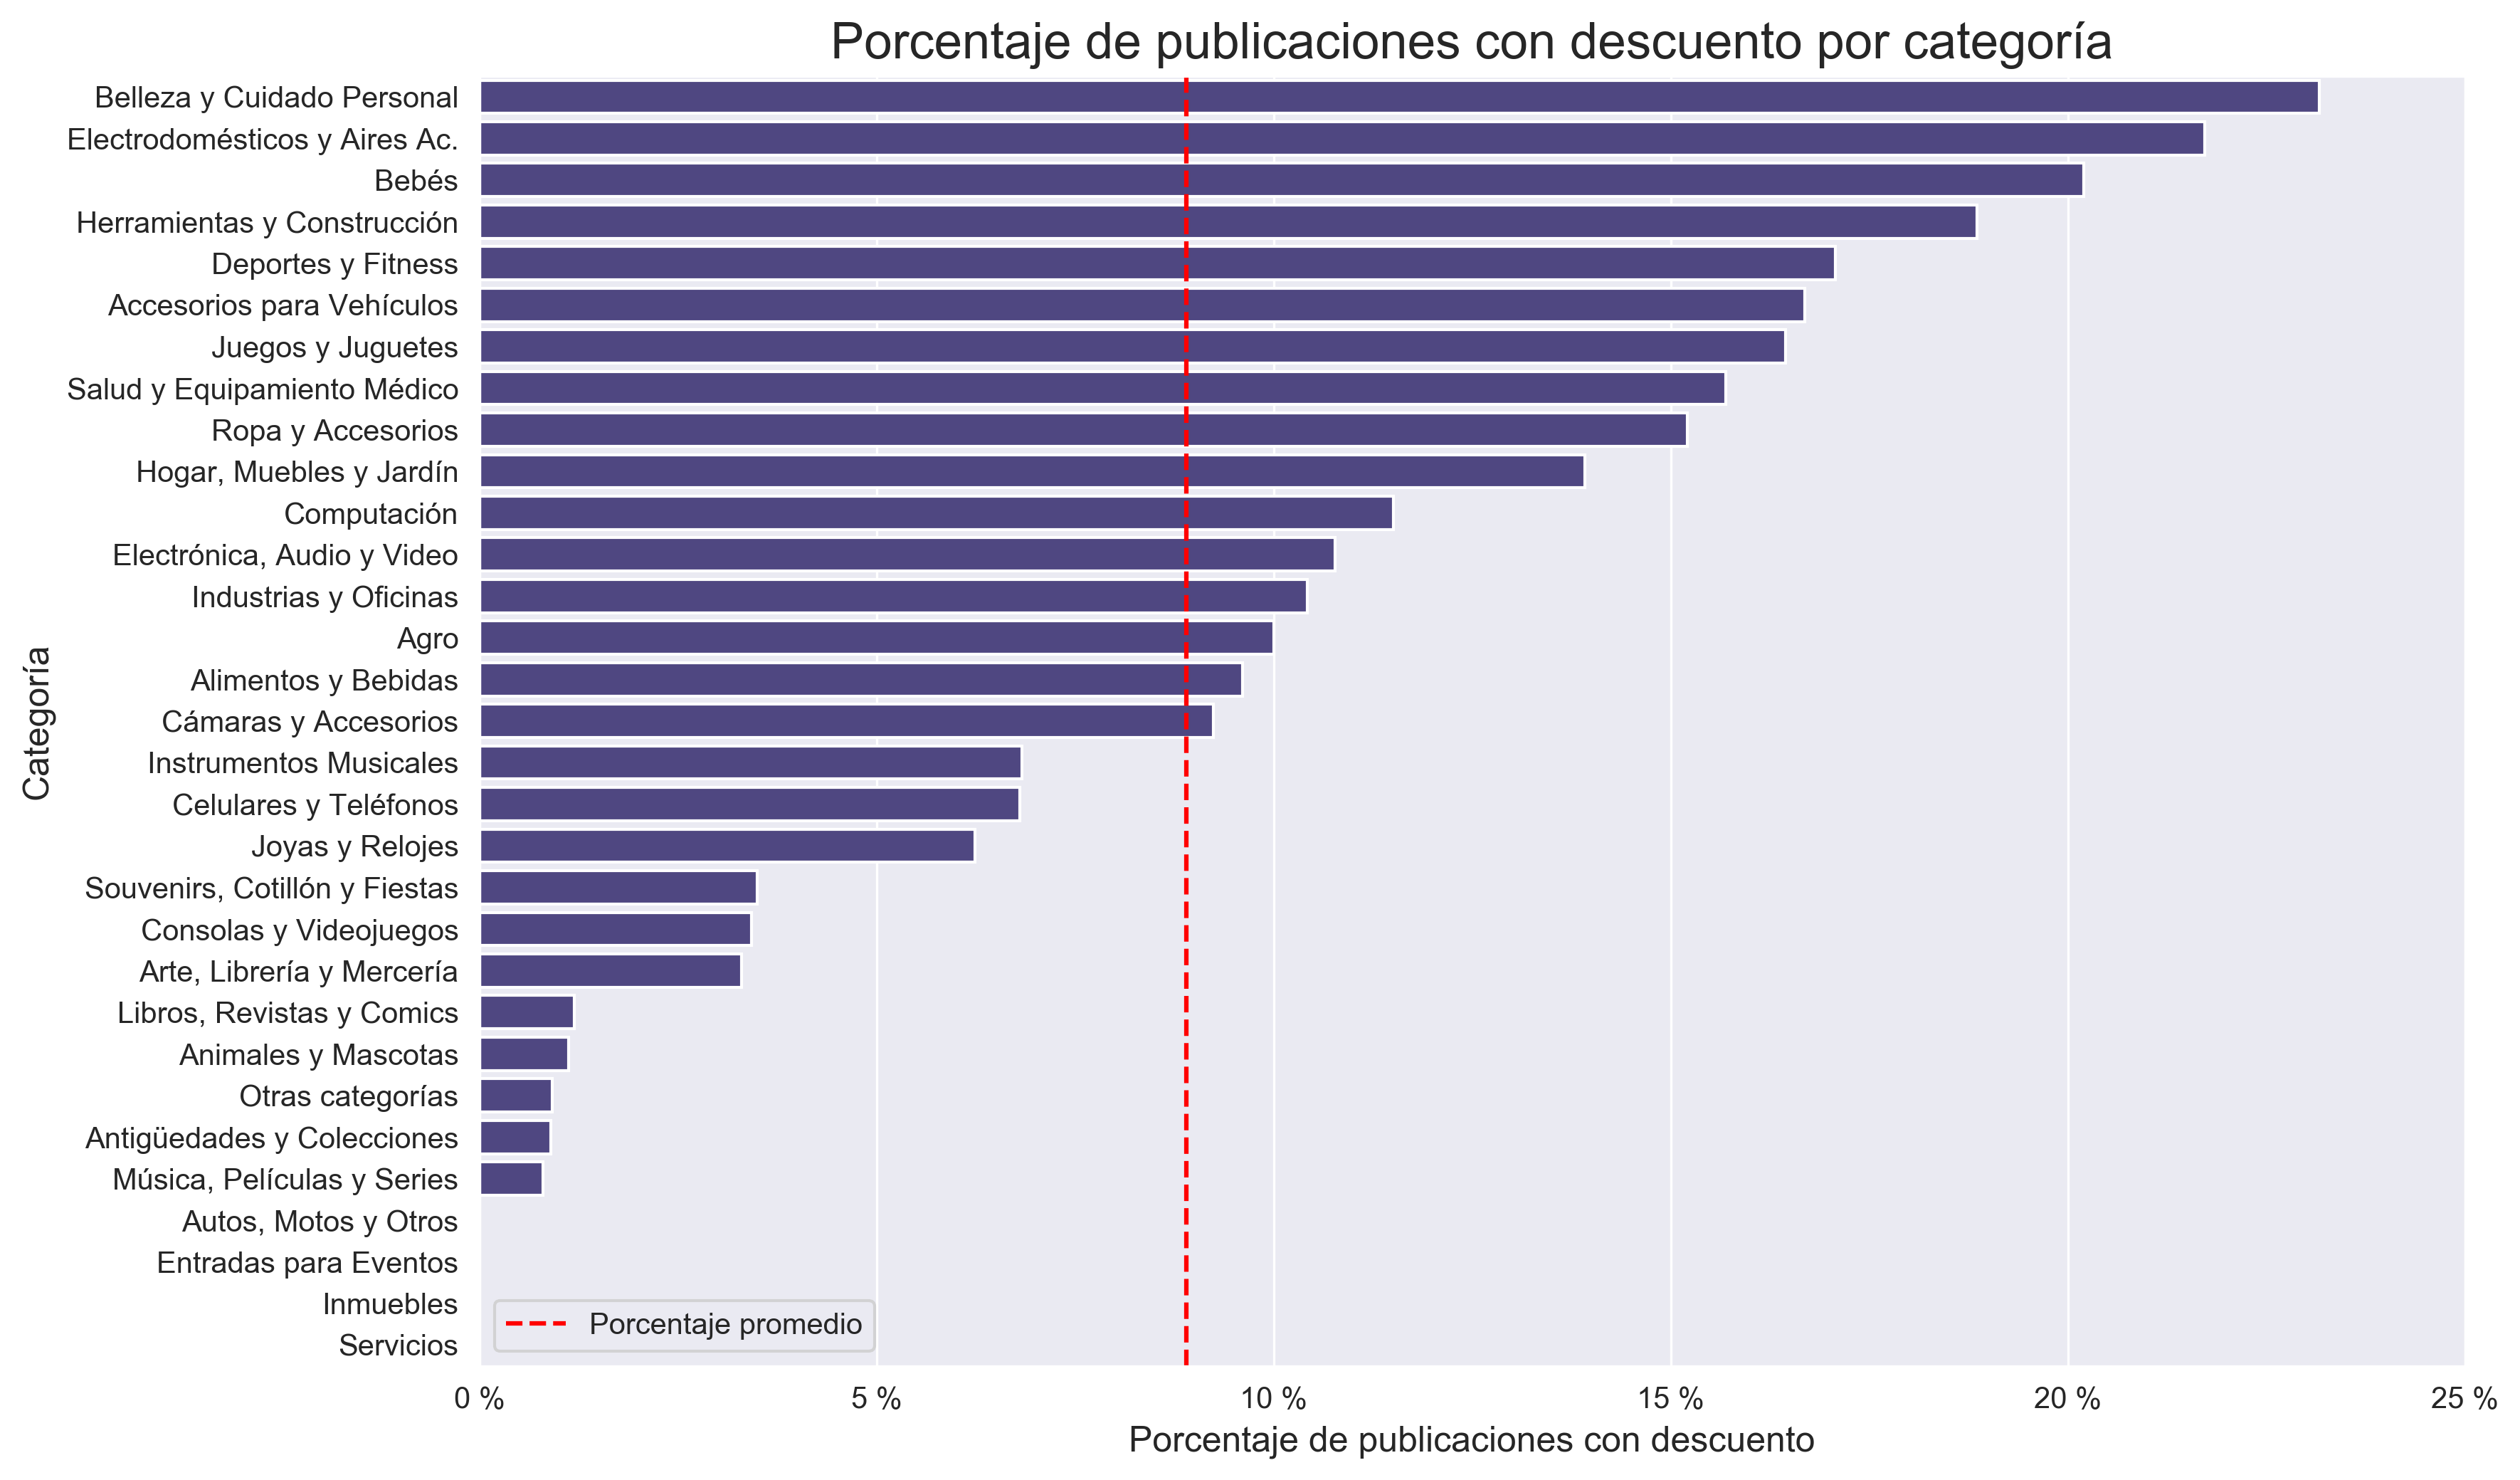

In [153]:
porc_publis_con_dcto = round(df_total["tiene_dcto"].mean() * 100, 1)

df_aux = df_total.groupby(["categoria_principal"])["tiene_dcto"].mean() * 100
df_aux = pd.DataFrame(df_aux).reset_index()
df_aux.rename(columns = {'tiene_dcto':'porc_con_dcto'}, inplace = True)
df_aux.sort_values("porc_con_dcto", ascending = False, inplace = True)

plt.figure(dpi=300)
sns.barplot(data = df_aux, x = "porc_con_dcto", y = "categoria_principal", 
            color = "darkslateblue", orient = "h")
plt.axvline(porc_publis_con_dcto, linestyle = "--", color = "r", label = "Porcentaje promedio")
xticks = np.arange(0, 30, 5)
plt.xticks(xticks, [str(int(item)) + " %" for item in xticks])

plt.title("Porcentaje de publicaciones con descuento por categoría", fontsize=17)
plt.xlabel("Porcentaje de publicaciones con descuento", fontsize=12)
plt.ylabel(u"Categoría", fontsize=12)
plt.legend()

plt.show()

**Observaciones**

- Ninguna de las categorías tiene más de 25% de publicaciones con descuento.

- El indicador de Porcentaje promedio (linea punteada roja) nos permite entender cuáles categorías tienen más publicaciones con descuento que la media y cuáles menos.

- Recordar que sólo se tomaron 1000 publicaciones de cada categoría, por lo que estos datos pueden no ser representativos.

## 6.2 - Para cada categoría, cúal es el descuento nominal promedio? <a id="6.2"></a>

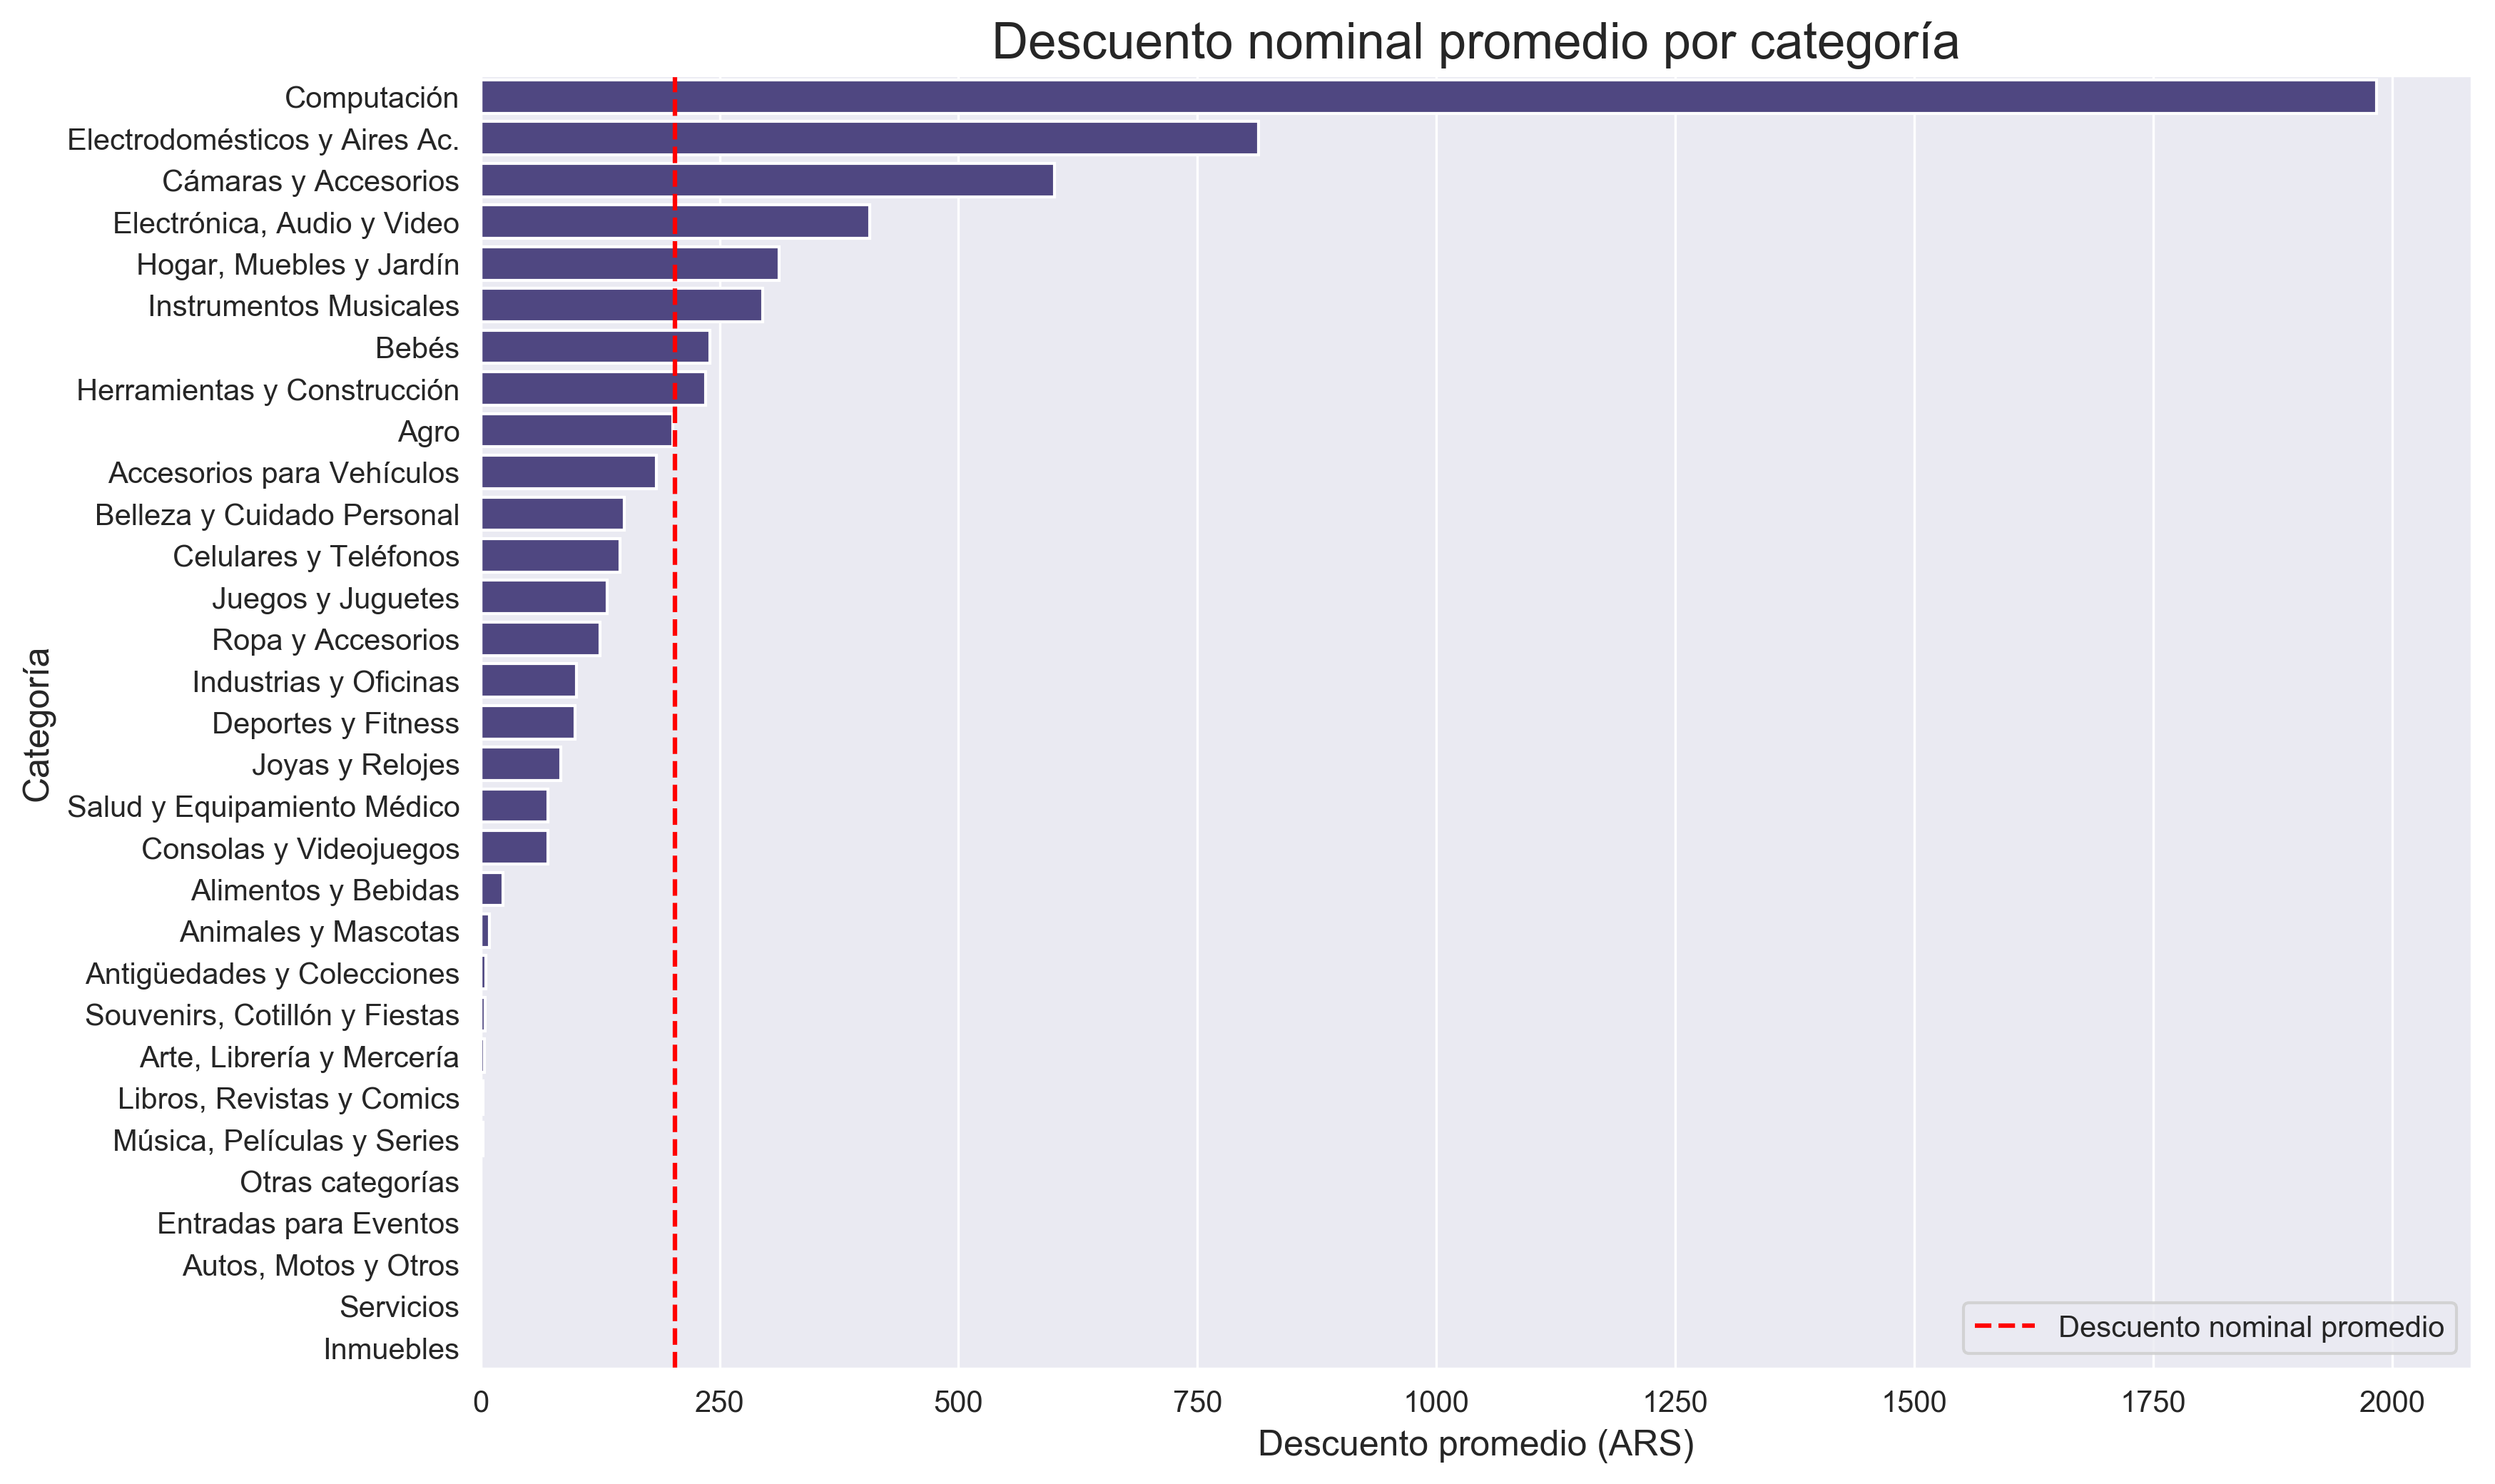

In [154]:
media_dcto_nominal = round(df_total["dcto_nominal"].mean(), 1)

df_aux = df_total.groupby(["categoria_principal"])["dcto_nominal"].mean()
df_aux = pd.DataFrame(df_aux).reset_index()
df_aux.rename(columns = {'dcto_nominal':'media_dcto_nominal'}, inplace = True)
df_aux.sort_values("media_dcto_nominal", ascending = False, inplace = True)

plt.figure(dpi=300)
sns.barplot(data = df_aux, x = "media_dcto_nominal", y = "categoria_principal", 
            color = "darkslateblue", orient = "h")
plt.axvline(media_dcto_nominal, linestyle = "--", color = "r", label = "Descuento nominal promedio")

plt.title("Descuento nominal promedio por categoría", fontsize=17)
plt.xlabel("Descuento promedio (ARS)", fontsize=12)
plt.ylabel(u"Categoría", fontsize=12)
plt.legend()

plt.show()

**Observaciones**

- Es probable que haya una correlación entre el descuento nominal y el precio de los items de cada categoría (productos más caros van a tener un mayor descuento nominal, pero esto no significa necesariamente que en proporción sea un descuento considerable).

- Es notorio el caso de la categoría "Electrodomésticos y Aires Ac.", que es la segunda categoría con mayor descuento nominal promedio y también la segunda con mayor proporción de publicaciones con descuento (~22%, mirar gráfico anterior).

## 6.3 - Para cada categoría, cúal es el descuento porcentual promedio? <a id="6.3"></a>

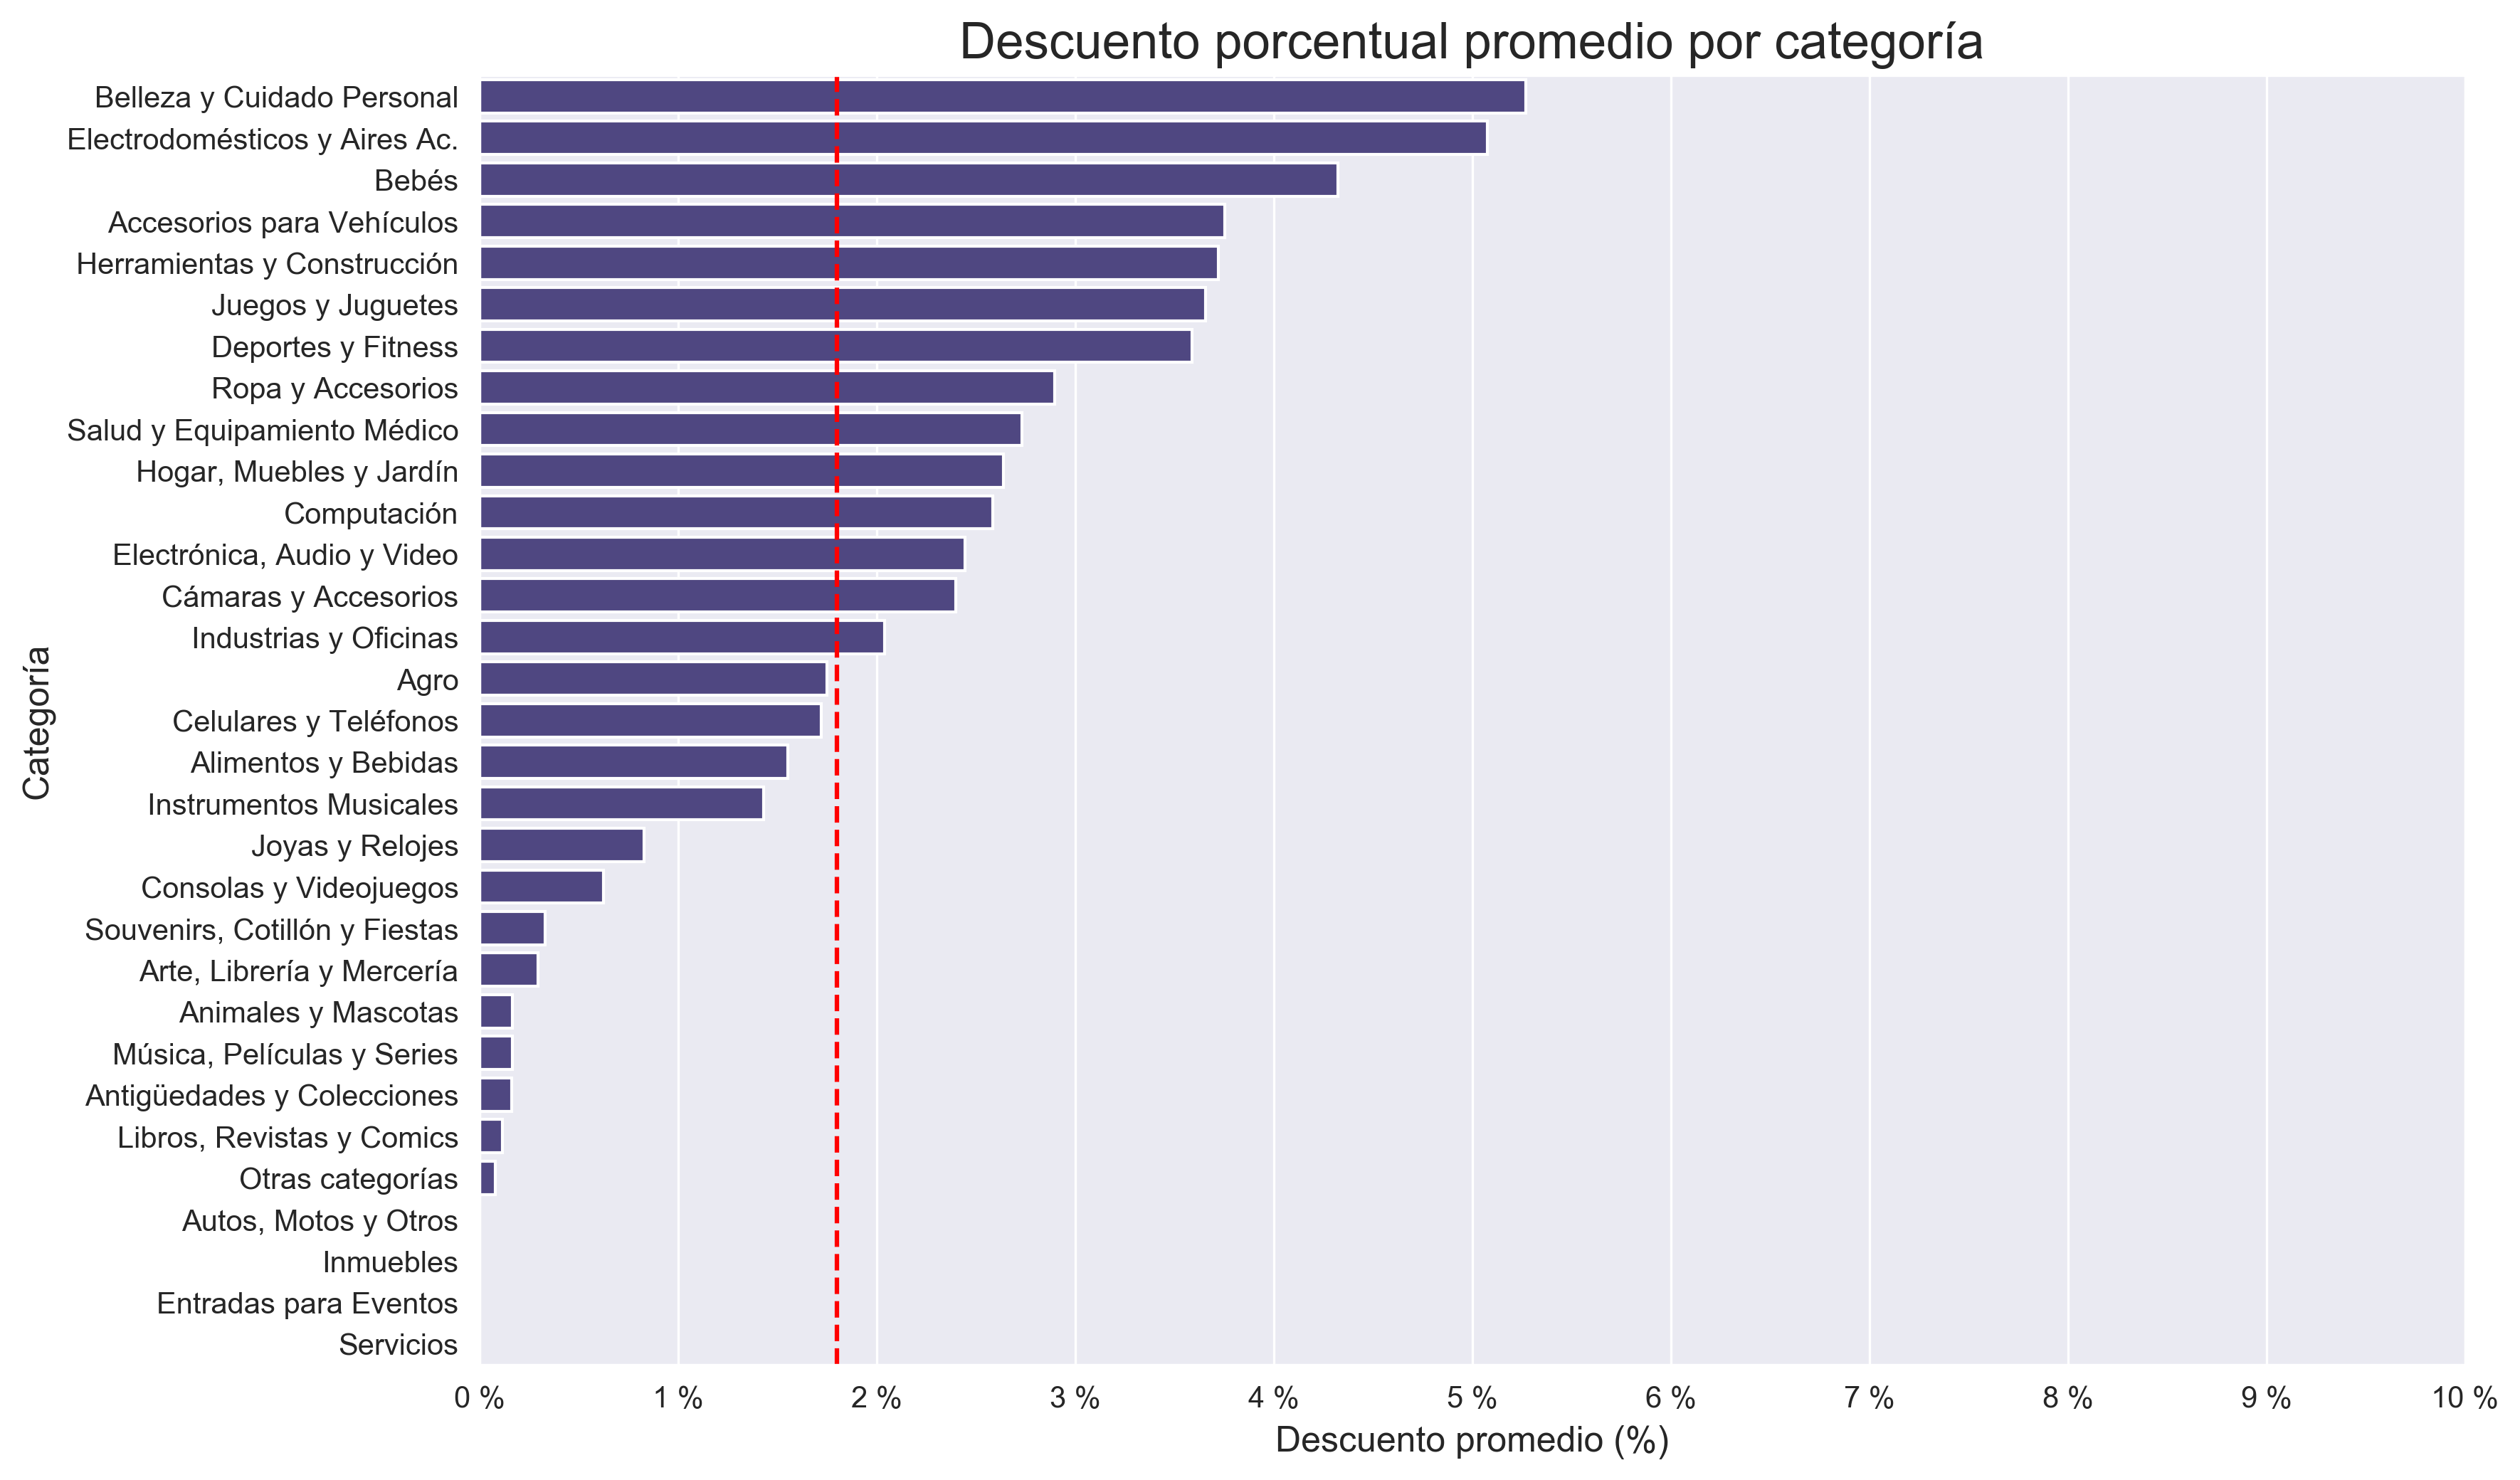

In [155]:
media_dcto_porcentual = round(df_total["dcto_porcentual"].mean(), 1)

df_aux = df_total.groupby(["categoria_principal"])["dcto_porcentual"].mean()
df_aux = pd.DataFrame(df_aux).reset_index()
df_aux.rename(columns = {'dcto_porcentual':'media_dcto_porcentual'}, inplace = True)
df_aux.sort_values("media_dcto_porcentual", ascending = False, inplace = True)

plt.figure(dpi=300)
sns.barplot(data = df_aux, x = "media_dcto_porcentual", y = "categoria_principal", 
            color = "darkslateblue", orient = "h")
plt.axvline(media_dcto_porcentual, linestyle = "--", color = "r", label = "Descuento porcentual promedio")
xticks = np.arange(0, 11, 1)
plt.xticks(xticks, [str(int(item)) + " %" for item in xticks])

plt.title("Descuento porcentual promedio por categoría", fontsize=17)
plt.xlabel("Descuento promedio (%)", fontsize=12)
plt.ylabel(u"Categoría", fontsize=12)
plt.show()

**Observaciones**

- Vemos que la categoría "Computación" que tiene el mayor promedio de descuento nominal, en esta tabla no está en el top 10. 

- Es notorio el caso de la categoría "Electrodomésticos y Aires Ac.", que es la segunda categoría con mayor descuento nominal promedio, también la segunda con mayor proporción de publicaciones con descuento (~22%, mirar gráfico anterior) y también la segunda con mayor descuento porcentual promedio! Esto hace pensar que tal vez se suelen inflar los precios de esta categoría (como por ejemplo con los colchones), o tal vez es algo estacional (aires acondicionados en invierno). 

- La categoría "Belleza y Cuidado Personal" es la que mayor porcentaje de publicaciones con descuento tiene y a su vez la que mayor descuento porcentual promedio ofrece!

## 6.4 - Para cada categoría, cómo se distribuye el descuento nominal? <a id="6.4"></a>

#### Teniendo en cuenta sólo las publicaciones con descuento

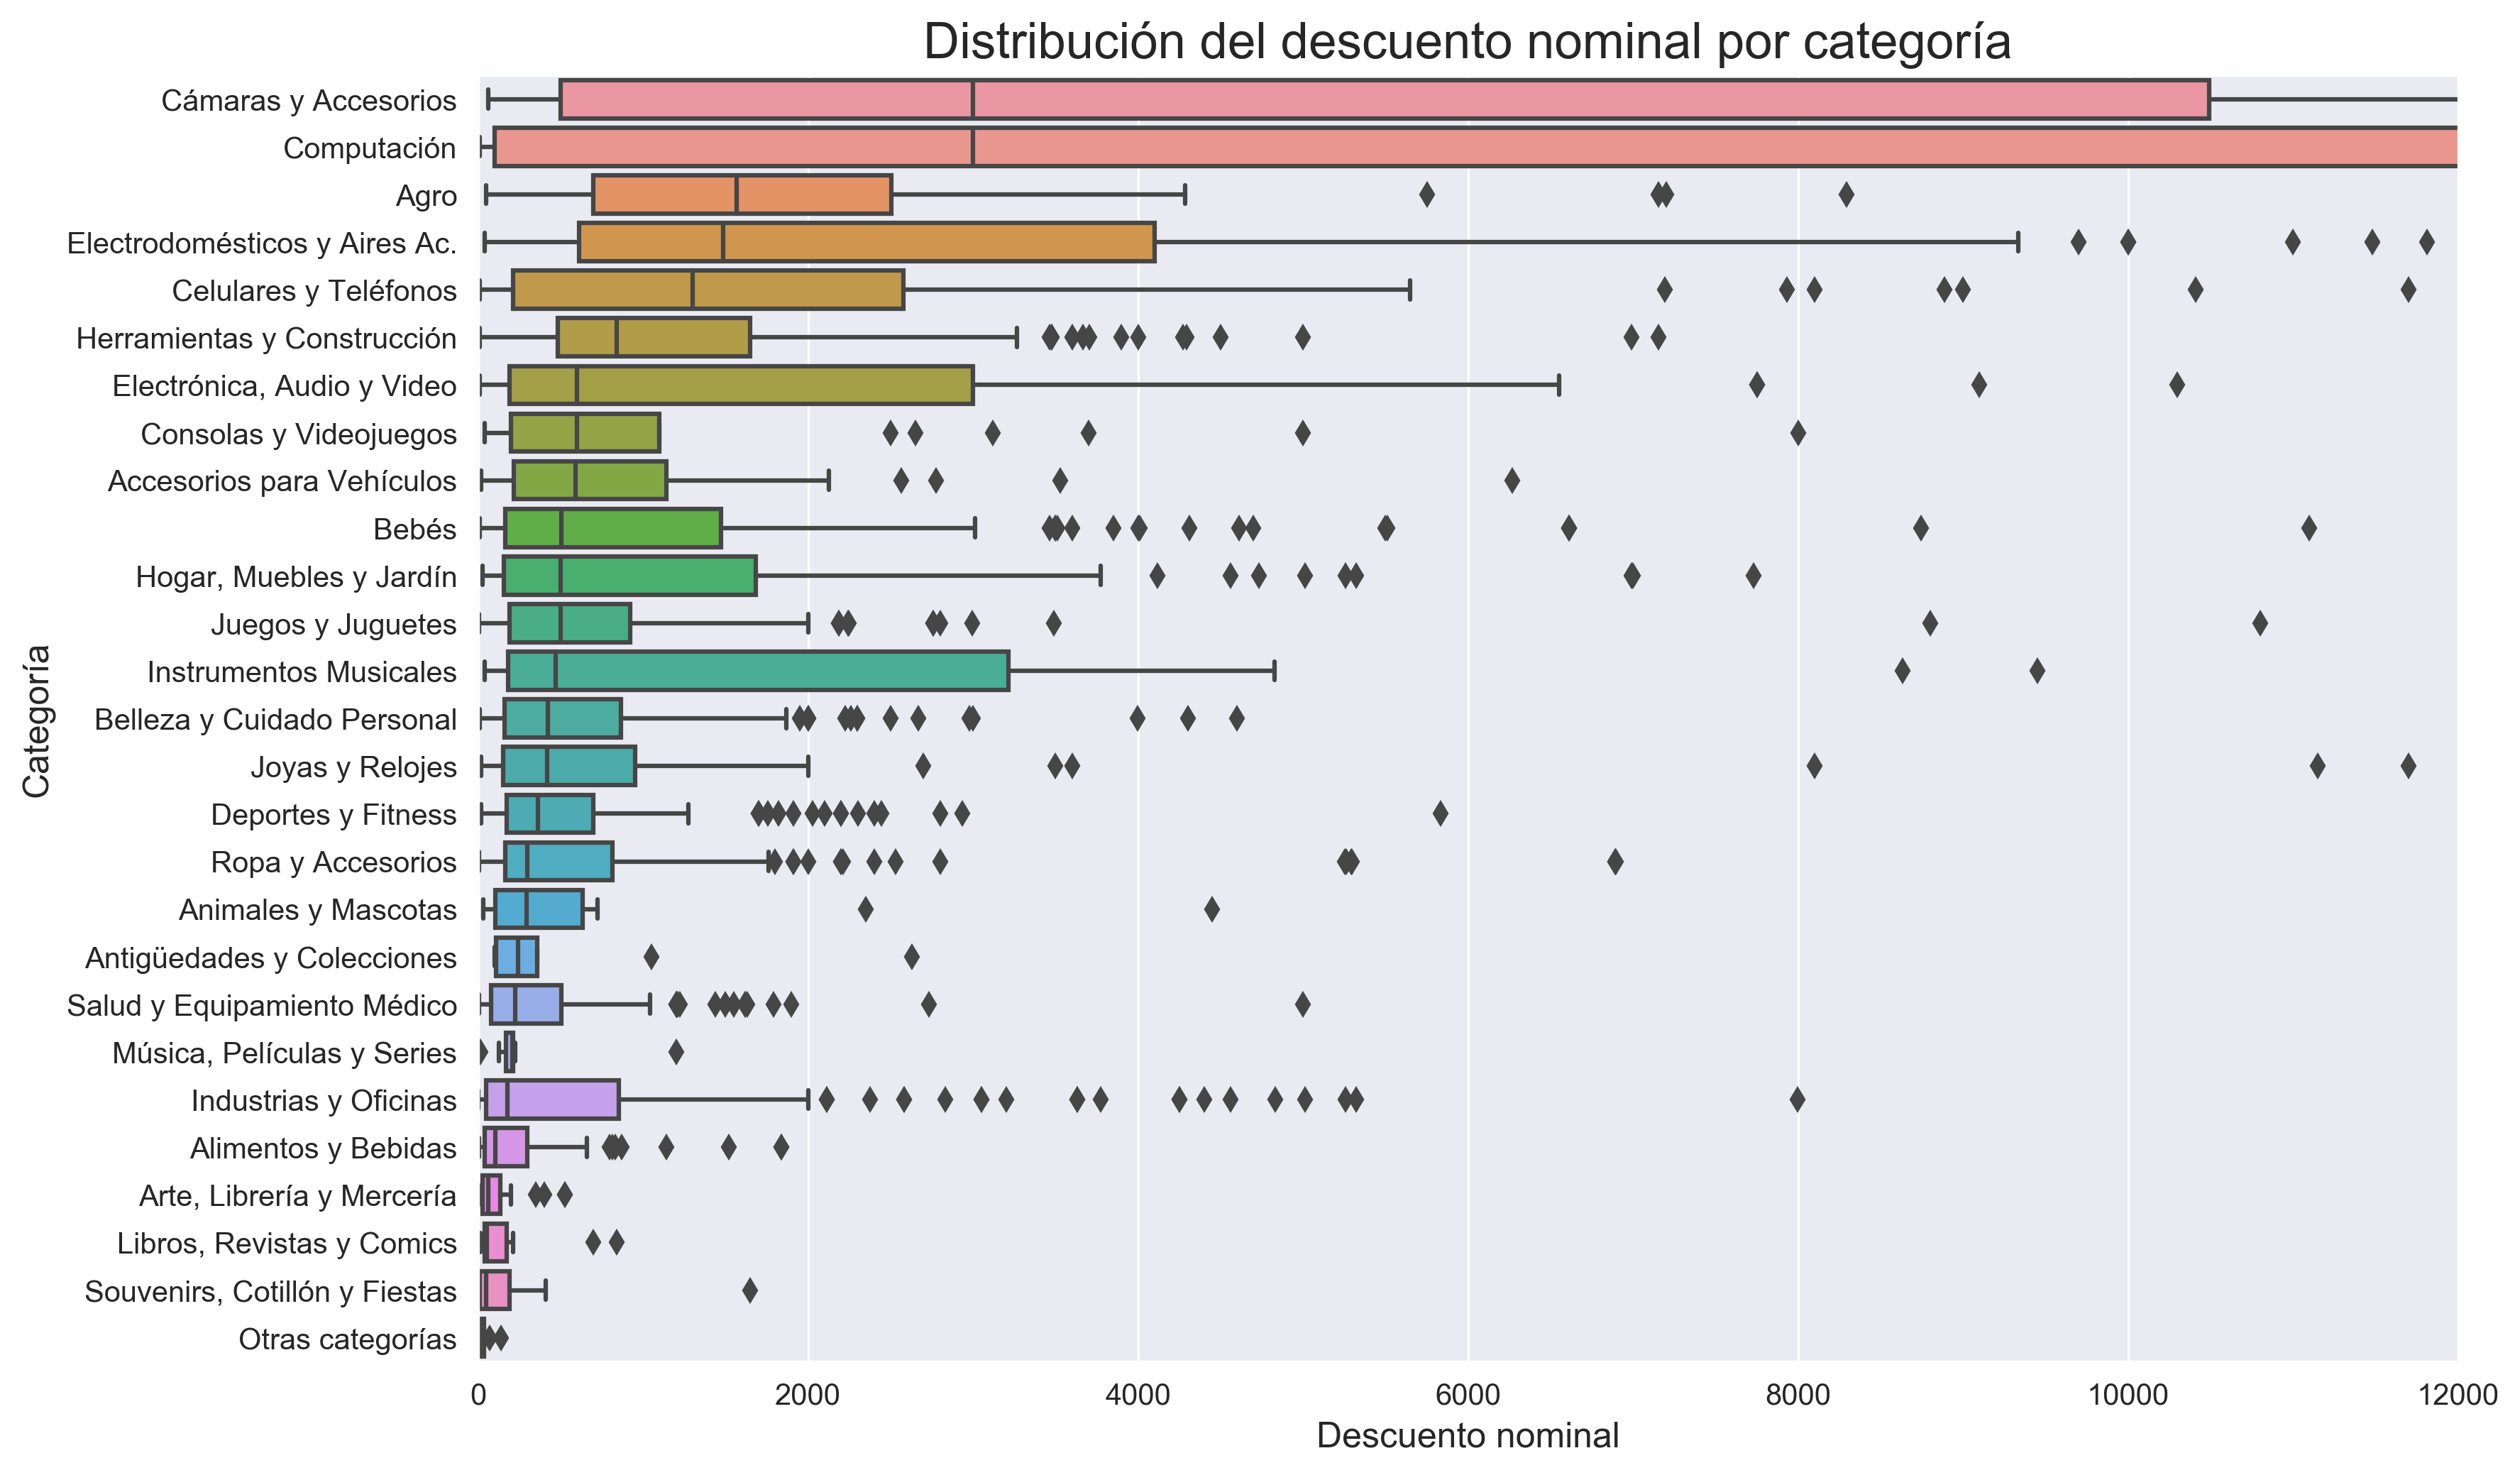

In [156]:
df_aux = df_total.copy()
filtro_dctos_positivos = df_aux["dcto_nominal"] > 0
df_aux = df_aux[filtro_dctos_positivos]

grouped = df_aux.groupby('categoria_principal')["dcto_nominal"].median()
grouped = pd.DataFrame(grouped)
orden_grupos = grouped.sort_values("dcto_nominal", ascending = False).index

plt.figure(dpi=300)
sns.boxplot(data = df_aux, y = "categoria_principal", x = "dcto_nominal", 
            orient = "h", order = orden_grupos)
plt.xlim(0,12000)

plt.title(u"Distribución del descuento nominal por categoría" , fontsize=17)
plt.xlabel("Descuento nominal", fontsize=12)
plt.ylabel(u"Categoría", fontsize=12)
plt.show()

**Observaciones**

- Las categorías "Cámaras y Accesorios", "Computación", "Electrodomésticos y Aires Ac.", "Electrónica, Audio y Video" e "Instrumentos Musicales" tienen una gran varianza. Esto puede deberse a que cada categoría contiene subcategorías muy diversas.

- Mirando las medianas tenemos un análisis más robusto de el descuento nominal "promedio" (aparecen algunas categorías nuevas en el top, como "Agro" y "Herramientas y Construcción").

- Una vez que se publica, se puede actualizar el precio del item? Si no se puede, tal vez la inflación influye en publicaciones que fijaron su precio (y su descuento) meses atrás.

## 6.5 - Para cada categoría, cómo se distribuye el descuento porcentual? <a id="6.5"></a>

#### Teniendo en cuenta sólo las publicaciones con descuento

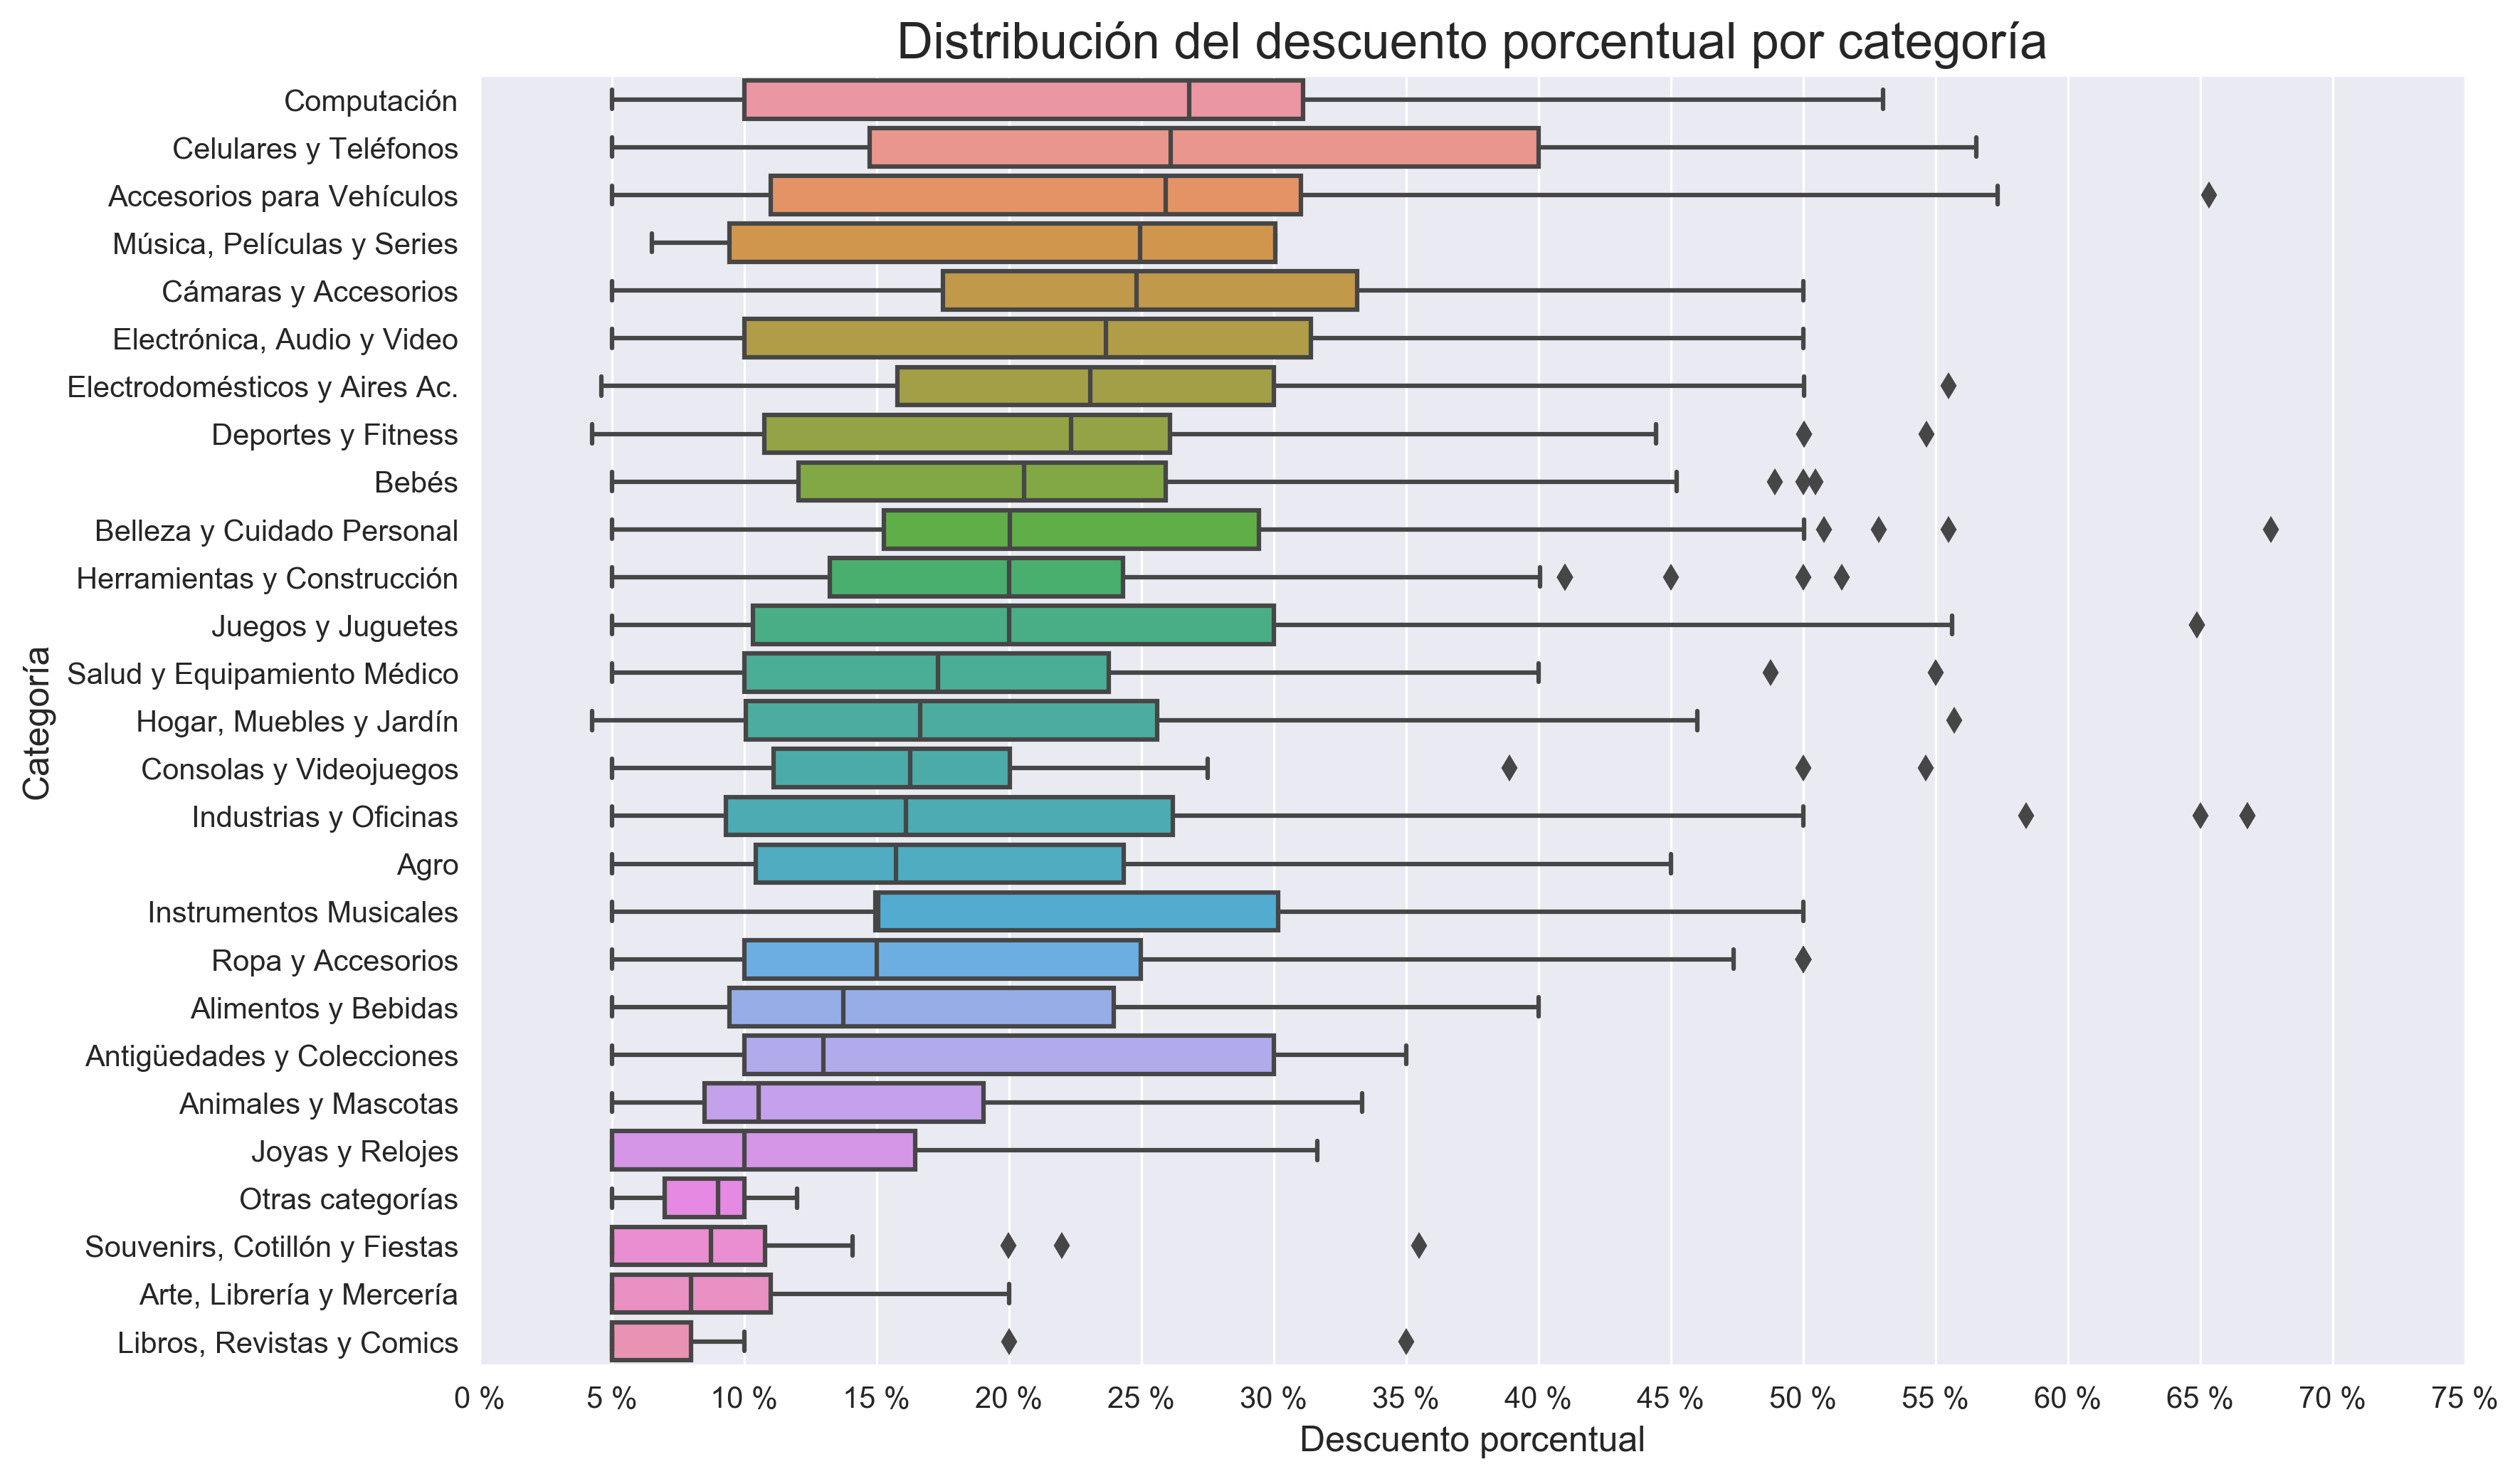

In [165]:
filtro_dctos_positivos = df_total["dcto_porcentual"] > 0
df_aux = df_total[filtro_dctos_positivos]

grouped = df_aux.groupby('categoria_principal')["dcto_porcentual"].median()
grouped = pd.DataFrame(grouped)
orden_grupos = grouped.sort_values("dcto_porcentual", ascending = False).index

plt.figure(dpi=300)
sns.boxplot(data = df_aux, y = "categoria_principal", x = "dcto_porcentual", 
            orient = "h", order = orden_grupos)
xticks = np.arange(0, 80, 5)
plt.xticks(xticks, [str(int(item)) + " %" for item in xticks])

plt.title(u"Distribución del descuento porcentual por categoría" , fontsize=17)
plt.xlabel("Descuento porcentual", fontsize=12)
plt.ylabel(u"Categoría", fontsize=12)

plt.show()

**Observaciones**

- Las varianzas son más parejas para la mayoría de las categorías.

- Mirando las medianas tenemos un análisis más robusto de el descuento porcentual "promedio" (aparecen algunas categorías nuevas en el top, como "Accesorios para Vehículos" y "Música, Películas y Series" - que aparecía en los últimos lugares en todos los gráficos!).

## 6.6 - Hay alguna relación entre la cantidad de publicaciones con descuento y el envío gratis? <a id="6.6"></a>

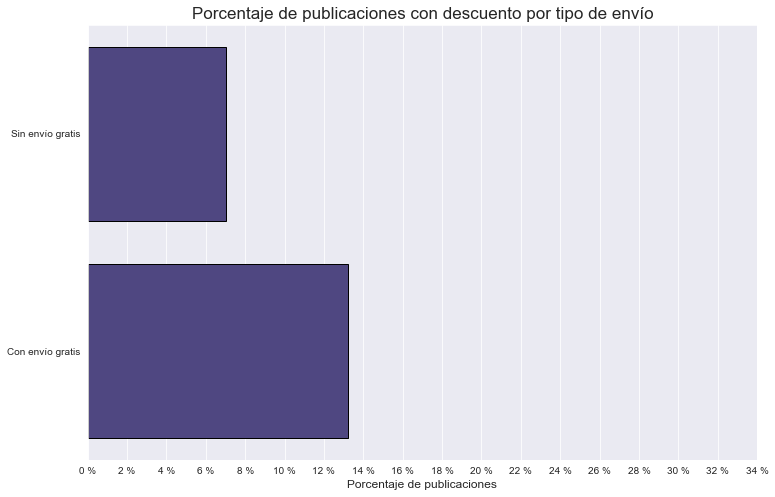

In [225]:
df_aux = df_total.copy(deep=True)
df_aux = df_aux.groupby('tiene_envio_gratis')["tiene_dcto"].mean() * 100
df_aux = pd.DataFrame(df_aux).reset_index()
df_aux.rename(columns = {'tiene_dcto':'porcentaje_con_dcto'}, inplace = True)
df_aux.replace({0:"Sin envío gratis", 1:"Con envío gratis"}, inplace = True)

#plt.figure()
sns.barplot(data = df_aux, x = "porcentaje_con_dcto", y = "tiene_envio_gratis", 
            color = "darkslateblue", orient = "h", edgecolor = "k")

xticks = np.arange(0, 35, 2)
plt.xticks(xticks, [str(int(item)) + " %" for item in xticks])

plt.title(u"Porcentaje de publicaciones con descuento por tipo de envío", fontsize=17)
plt.xlabel("Porcentaje de publicaciones", fontsize=12)
plt.ylabel("")
plt.show()

**Observaciones**

- Las publicaciones con envío gratis tienen aproximadamente el doble de porcentaje de publicaciones con descuento! Esto me sorprendió porque pienso que si una publicación da envío gratis en general no va a dar descuento. (Tal vez se podría hacer un análisis más profundo agregando la ubicación geográfica).

## 6.7 - Hay alguna relación entre la cantidad de publicaciones con descuento y la condición del item? <a id="6.7"></a>

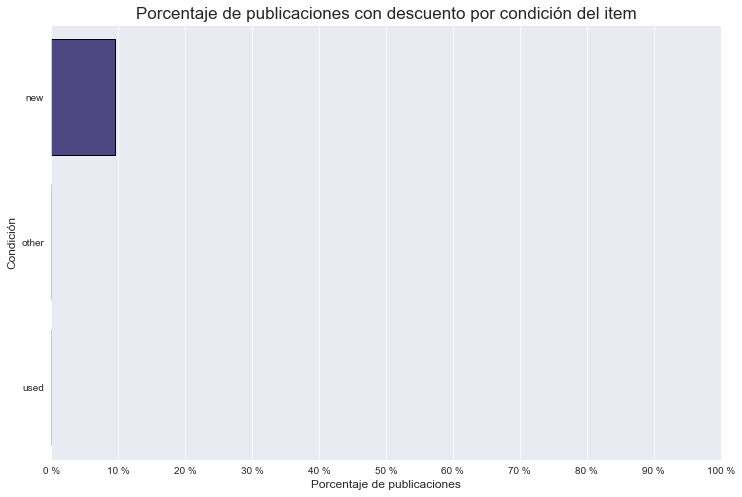

In [226]:
df_aux = df_total.copy(deep=True)
df_aux = df_aux.groupby('condicion')["tiene_dcto"].mean() * 100
df_aux = pd.DataFrame(df_aux).reset_index()
df_aux.rename(columns = {'tiene_dcto':'porcentaje_con_dcto'}, inplace = True)

sns.barplot(data = df_aux, x = "porcentaje_con_dcto", y = "condicion", 
            color = "darkslateblue", orient = "h", edgecolor = "k")
xticks = np.arange(0, 110, 10)
plt.xticks(xticks, [str(int(item)) + " %" for item in xticks])

plt.title(u"Porcentaje de publicaciones con descuento por condición del item", fontsize=17)
plt.xlabel("Porcentaje de publicaciones", fontsize=12)
plt.ylabel("Condición", fontsize=12)
plt.show()

**Observaciones**

- Imaginaba que las publicaciones de items usados iban a tener más proporción de descuento que los items nuevos! 

- Que el porcentaje de publicaciones con descuento para items nuevos sea ~10% no nos dice mucho, ya que le promedio general era ~8% y estamos sacando del análisis las publicaciones con items usados u "otros" que no tienen descuento, por lo que es razonable que el porcentaje suba.

## 6.8 - Hay alguna relación entre la cantidad de publicaciones con descuento y la zona geográfica? <a id="6.8"></a>

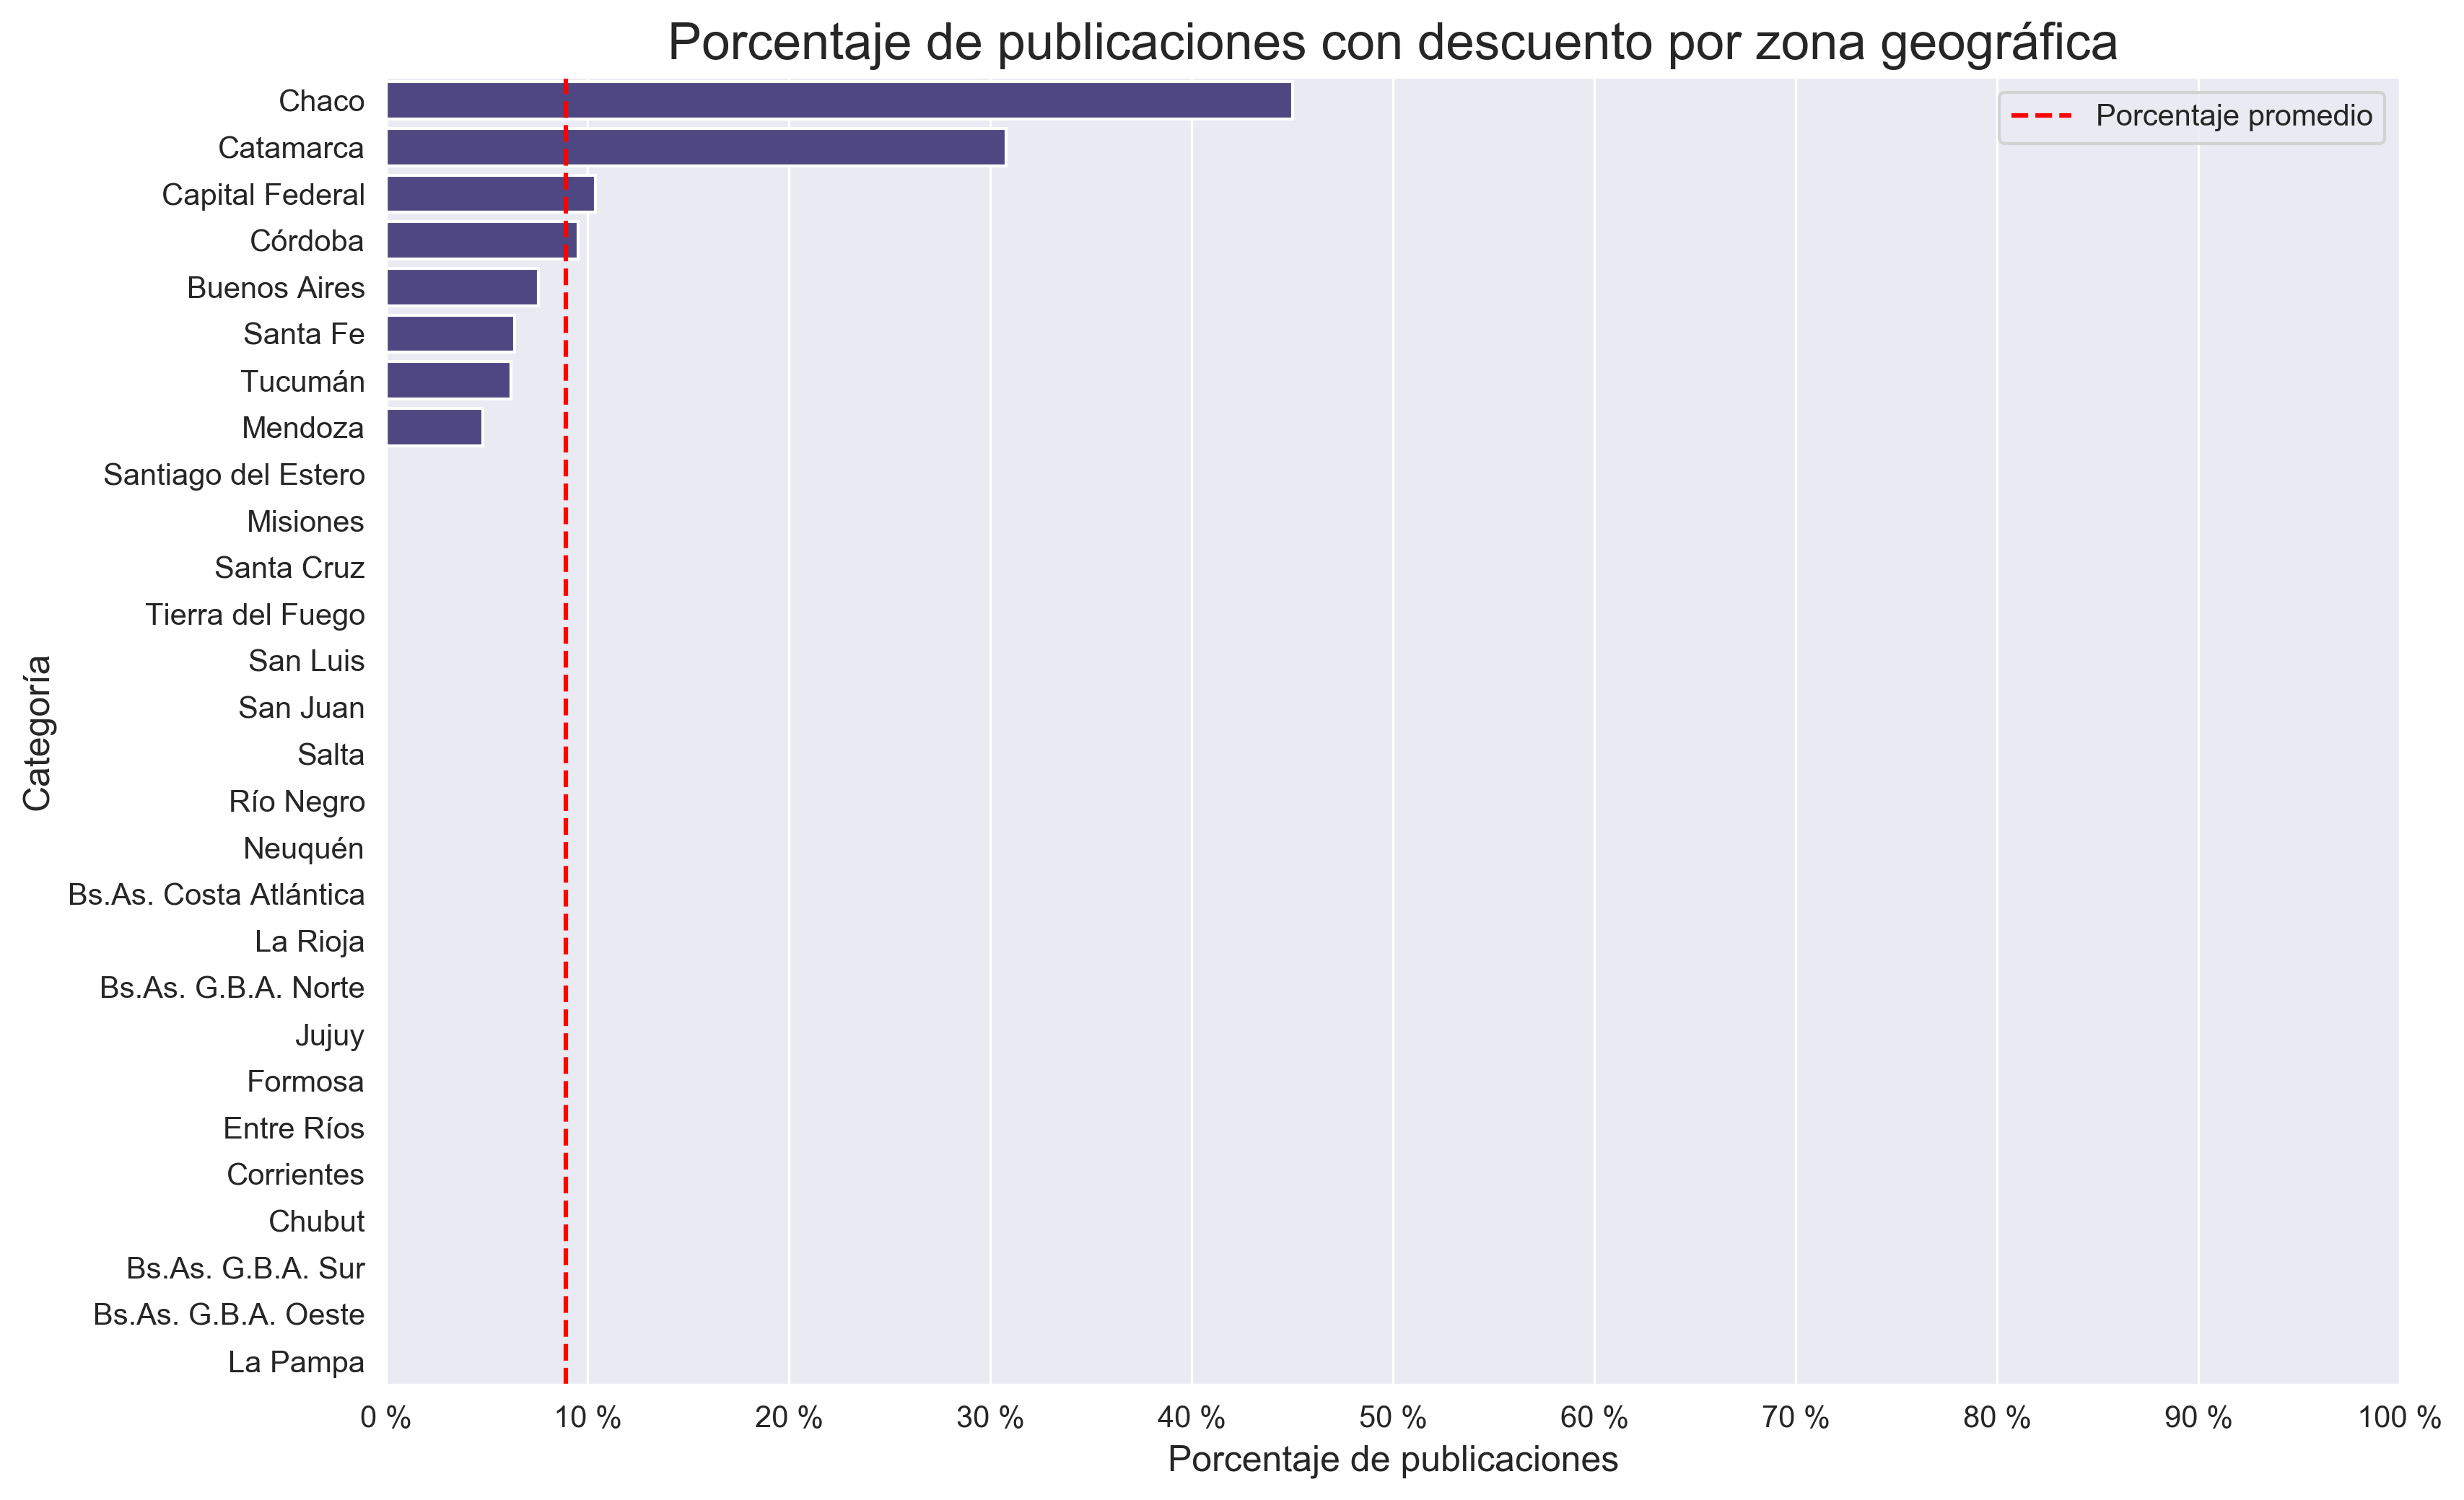

In [236]:
porc_publis_con_dcto = round(df_total["tiene_dcto"].mean() * 100, 1)

df_aux = df_total.groupby(["nombre_zona"])["tiene_dcto"].mean() * 100
df_aux = pd.DataFrame(df_aux).reset_index()
df_aux.rename(columns = {'tiene_dcto':'porcentaje_publicaciones_con_dcto'}, inplace = True)
df_aux.sort_values("porcentaje_publicaciones_con_dcto", ascending = False, inplace = True)

plt.figure(dpi=300)
sns.barplot(data = df_aux, x = "porcentaje_publicaciones_con_dcto", y = "nombre_zona", 
            color = "darkslateblue", orient = "h")
plt.axvline(porc_publis_con_dcto, linestyle = "--", color = "r", label = "Porcentaje promedio")
xticks = np.arange(0, 110, 10)
plt.xticks(xticks, [str(int(item)) + " %" for item in xticks])

plt.title(u"Porcentaje de publicaciones con descuento por zona geográfica", fontsize=17)
plt.xlabel("Porcentaje de publicaciones", fontsize=12)
plt.ylabel(u"Categoría", fontsize=12)
plt.legend()
plt.show()

**Observaciones**

- Todas las zonas (excepto Capital Federal, Buenos Aires, Santa Fe y Córdoba) tienen menos de 500 publicaciones, por lo que no voy a hacer ningún análisis de este gráfico por falta de representatividad.

In [234]:
df_total.groupby(["nombre_zona"])["tiene_dcto"].size().sort_values(ascending = False)

nombre_zona
Capital Federal           18067
Buenos Aires               8736
Santa Fe                    958
Córdoba                     662
Bs.As. G.B.A. Norte         460
Bs.As. G.B.A. Oeste         273
Bs.As. G.B.A. Sur           239
Mendoza                     125
Entre Ríos                  120
Tucumán                      97
Bs.As. Costa Atlántica       43
Misiones                     40
La Pampa                     23
Salta                        23
Chaco                        20
Neuquén                      17
Corrientes                   17
Río Negro                    13
Catamarca                    13
San Juan                     11
Jujuy                        11
Chubut                        9
San Luis                      7
Tierra del Fuego              6
Santiago del Estero           6
La Rioja                      4
Santa Cruz                    3
Formosa                       2
Name: tiene_dcto, dtype: int64

## 6.9 - Hay alguna relación entre la cantidad de publicaciones con descuento y la cantidad de items vendidos? <a id="6.9"></a>

C:\Users\f.costa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\f.costa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


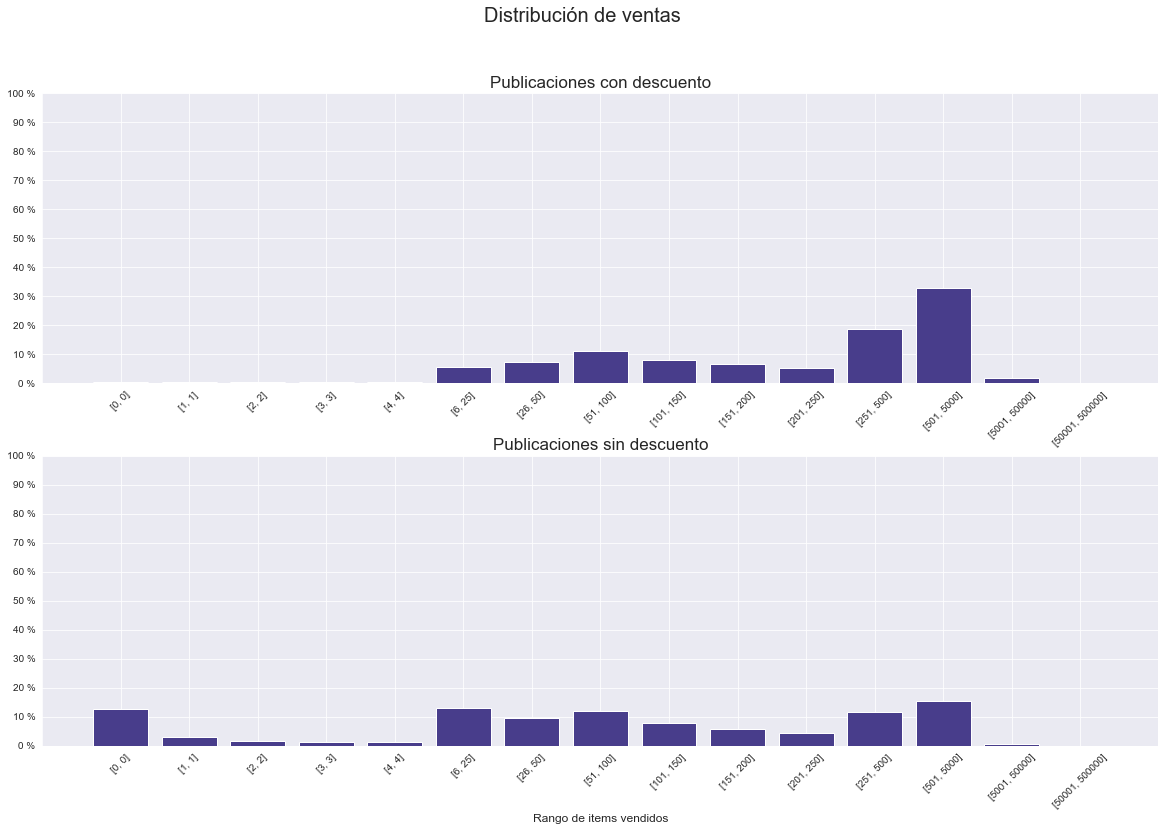

In [218]:
df_aux = df_total.groupby(["tiene_dcto", "rango_items_vendidos"]).size()
df_aux = pd.DataFrame(df_aux).reset_index()
df_aux.rename(columns = {0:'cantidad'}, inplace = True)
df_aux_con_dcto = df_aux[df_aux["tiene_dcto"] == 1]
df_aux_sin_dcto = df_aux[df_aux["tiene_dcto"] == 0]
df_aux_con_dcto["porcentaje"] = df_aux_con_dcto["cantidad"] * 100 / df_aux_con_dcto["cantidad"].sum()
df_aux_sin_dcto["porcentaje"] = df_aux_sin_dcto["cantidad"] * 100 / df_aux_sin_dcto["cantidad"].sum()

fig = plt.figure(figsize=(20, 12)) 
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.1, hspace=.25)

ax1 = fig.add_subplot(211)
plt.bar(df_aux_con_dcto["rango_items_vendidos"].astype("str"), df_aux_con_dcto["porcentaje"], color = "darkslateblue")
plt.xticks(rotation = 45)
yticks = np.arange(0, 110, 10)
plt.yticks(yticks, [str(int(item)) + " %" for item in yticks])
plt.ylim(0,100)
plt.title("Publicaciones con descuento", fontsize = 17)

ax2 = fig.add_subplot(212)
plt.bar(df_aux_sin_dcto["rango_items_vendidos"].astype("str"), df_aux_sin_dcto["porcentaje"], color = "darkslateblue")
plt.xticks(rotation = 45)
yticks = np.arange(0, 110, 10)
plt.yticks(yticks, [str(int(item)) + " %" for item in yticks])
plt.ylim(0,100)
plt.title("Publicaciones sin descuento", fontsize = 17)
plt.xlabel("Rango de items vendidos", fontsize=12)

plt.suptitle("Distribución de ventas", fontsize = 20)
plt.show()

**Observaciones**

- La distribución de las publicaciones con descuento tiene una clara inclinación a la derecha! Esto quiere decir que en general, las publicaciones con descuento suelen vender más items. De todas maneras hay que tener cuidado, porque puede haber una correlación entre el descuento y el stock!

- Es notable la diferencia en los primeros 5 intervalos! Casi todas las publicaciones con descuento venden 6 items o más.

## 6.10 - Hay alguna relación entre la cantidad de publicaciones con descuento y la cantidad de stock? <a id="6.10"></a>

C:\Users\f.costa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\f.costa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


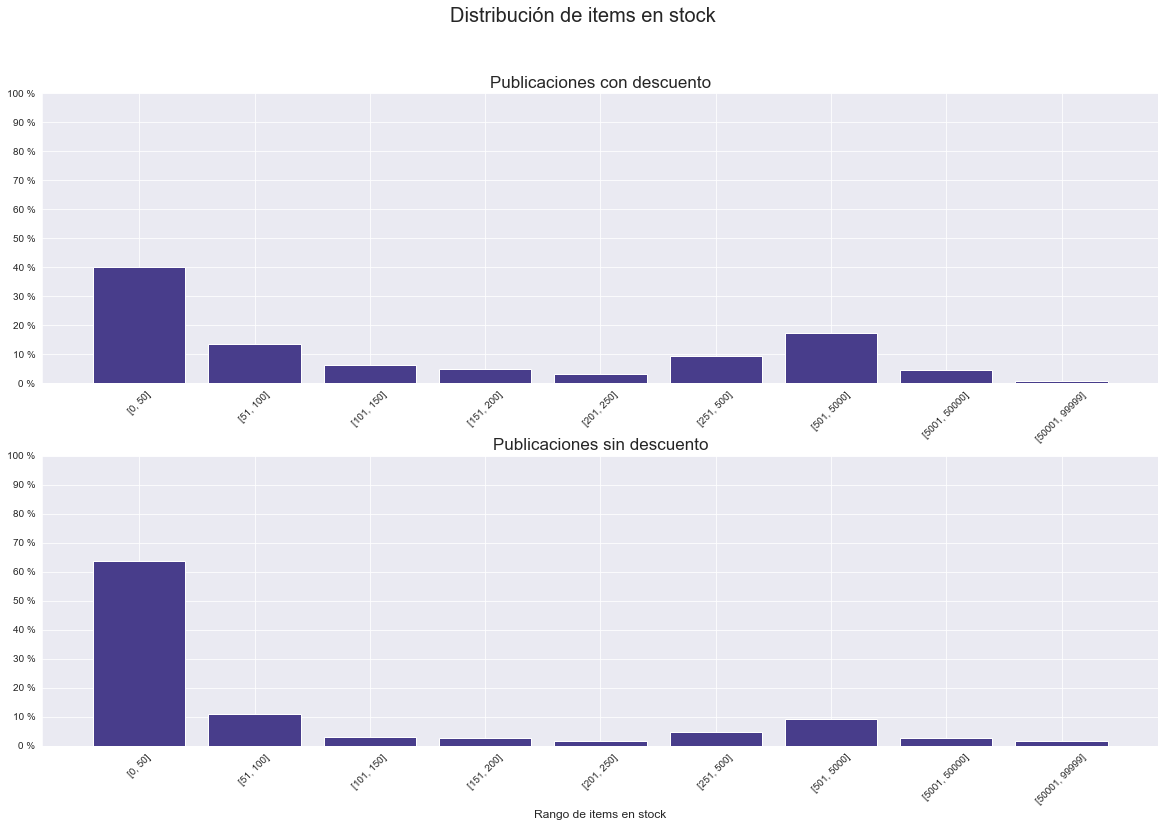

In [222]:
df_aux = df_total.groupby(["tiene_dcto", "rango_stock"]).size()
df_aux = pd.DataFrame(df_aux).reset_index()
df_aux.rename(columns = {0:'cantidad'}, inplace = True)
df_aux_con_dcto = df_aux[df_aux["tiene_dcto"] == 1]
df_aux_sin_dcto = df_aux[df_aux["tiene_dcto"] == 0]
df_aux_con_dcto["porcentaje"] = df_aux_con_dcto["cantidad"] * 100 / df_aux_con_dcto["cantidad"].sum()
df_aux_sin_dcto["porcentaje"] = df_aux_sin_dcto["cantidad"] * 100 / df_aux_sin_dcto["cantidad"].sum()

fig = plt.figure(figsize=(20, 12)) 
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.1, hspace=.25)

ax1 = fig.add_subplot(211)
plt.bar(df_aux_con_dcto["rango_stock"].astype("str"), df_aux_con_dcto["porcentaje"], color = "darkslateblue")
plt.xticks(rotation = 45)
yticks = np.arange(0, 110, 10)
plt.yticks(yticks, [str(int(item)) + " %" for item in yticks])
plt.ylim(0,100)
plt.title("Publicaciones con descuento", fontsize = 17)

ax2 = fig.add_subplot(212)
plt.bar(df_aux_sin_dcto["rango_stock"].astype("str"), df_aux_sin_dcto["porcentaje"], color = "darkslateblue")
plt.xticks(rotation = 45)
yticks = np.arange(0, 110, 10)
plt.yticks(yticks, [str(int(item)) + " %" for item in yticks])
plt.ylim(0,100)
plt.title("Publicaciones sin descuento", fontsize = 17)
plt.xlabel("Rango de items en stock", fontsize=12)

plt.suptitle("Distribución de items en stock", fontsize = 20)
plt.show()

**Observaciones**

- La distribución de las publicaciones con descuento tiene una inclinación a la derecha con respecto a la distribución de las publicaciones sin descuento. Esto quiere decir que en general, las publicaciones con más stock suelen hacer más descuento. (Hacen descuento porque necesitan sacarse de encima stock o hacen descuento porque tener mayor volumen de stock se los permite?).

- Es notable la diferencia en el intervalo [0, 50]. El ~60% de las publicaciones sin descuento tienen un stock entre 0 y 50, mientras que en el caso de las publicaciones con descuento es un ~40% (diferencia de ~20%!). 